In [ ]:
# !pip install numpy opencv-python pillow albumentations tensorflow kagglehub

In [ ]:
# !pip install keras

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import timm

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision.models as models

from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
import kagglehub

# Free download
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [ ]:
# Set to a number to specify size of training data; should be an even number
# None = max training size
# TRAIN_SIZE = 10000
TRAIN_SIZE = None

In [ ]:
!nvidia-smi

Mon Apr 21 23:19:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   71C    P0             32W /   72W |     261MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available, using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU. Too bad!!")

CUDA is available, using GPU.


In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set fixed seed
set_seed(42)

In [ ]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! chmod 600 /content/kaggle.json
# ! kaggle datasets list

In [ ]:
# Load the dataset
base_dir = path
df_path = "/content"
train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")
# train_df = pd.read_csv(os.path.join(df_path, "train_5000.csv"))
# test_df = pd.read_csv(os.path.join(df_path, "test_1000.csv"))

# Display basic info
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Reduce size of train dataset for easier processing
if TRAIN_SIZE is not None and TRAIN_SIZE < train_df.shape[0]:
  train_df = train_df.loc[0:(TRAIN_SIZE - 1)]
  print("Train dataset shape after reduction:", train_df.shape)
train_df.head()
train_df.shape

Train dataset shape: (79950, 3)
Test dataset shape: (5540, 1)


(79950, 3)

In [ ]:
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df.head()

file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1

In [ ]:
# Add base directory to all file_name fields to make it easier to read each image
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(base_dir, x))
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(base_dir, x))
# test_df['id'] = test_df['id'].apply(lambda x: os.path.join(base_dir + "/test_data_v2", x))
# train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(base_dir + "/train_data", x))

In [ ]:
print(train_df['file_name'].iloc[0])

/kaggle/input/ai-vs-human-generated-dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg


In [ ]:
print(test_df['id'].iloc[0])

/kaggle/input/ai-vs-human-generated-dataset/test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg


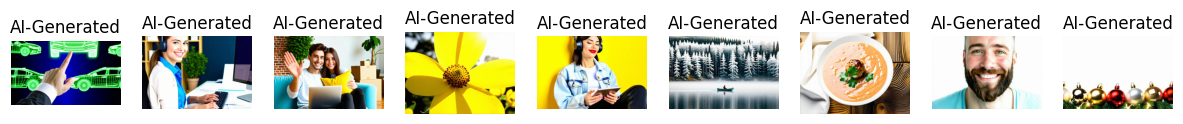

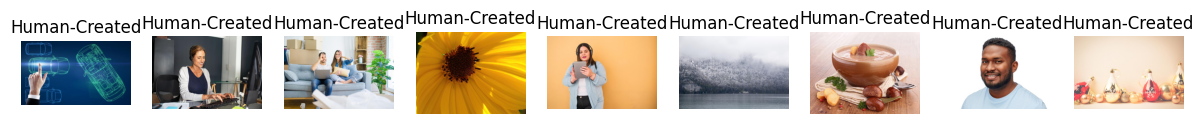

In [ ]:
# Function to display images
def show_images(df, label, num_images=9):
    sample_images = df[df["label"] == label].sample(num_images, random_state=15)["file_name"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("AI-Generated" if label == 1 else "Human-Created")

    plt.show()

# Show AI-Generated Images
show_images(train_df, label=1)

# Show Human-Created Images
show_images(train_df, label=0)

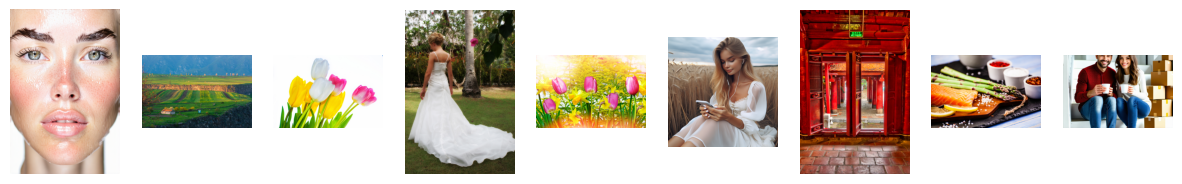

In [ ]:
def show_test_images(df, num_images=9):
    sample_images = df.sample(num_images, random_state=15)["id"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        # plt.title("AI-Generated" if label == 1 else "Human-Created")

    plt.show()

show_test_images(test_df)


First 5 rows of train.csv:
                                           file_name  label
0  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
1  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
2  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
3  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
4  /kaggle/input/ai-vs-human-generated-dataset/tr...      1


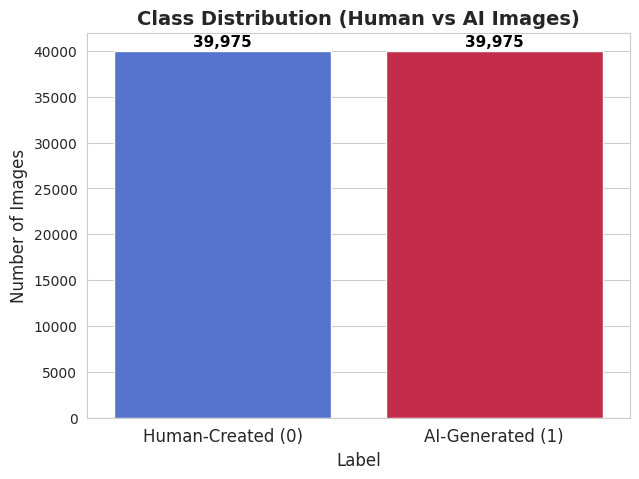

In [ ]:
# Modified from Victor's notebook
df = train_df

# Print the first few rows of train.csv
print("\nFirst 5 rows of train.csv:")
print(df.head())

# Extract only the filename (remove "train_data/" prefix)
# df["file_name"] = df["file_name"].apply(lambda x: os.path.basename(x))

# Construct full image path
# df["full_path"] = df["file_name"].apply(lambda x: os.path.join(DATASET_DIR, x))

# Convert label column to integer
df["label"] = df["label"].astype(int)

# Class Distribution
label_counts = df["label"].value_counts().sort_index()

# Plot Class Distribution
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=["royalblue", "crimson"])
plt.xticks(ticks=[0, 1], labels=["Human-Created (0)", "AI-Generated (1)"], fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.title("Class Distribution (Human vs AI Images)", fontsize=14, fontweight="bold")

# Add text labels on bars
for i, count in enumerate(label_counts.values):
    ax.text(i, count + 500, f"{count:,}", ha='center', fontsize=11, fontweight="bold", color="black")

plt.show()

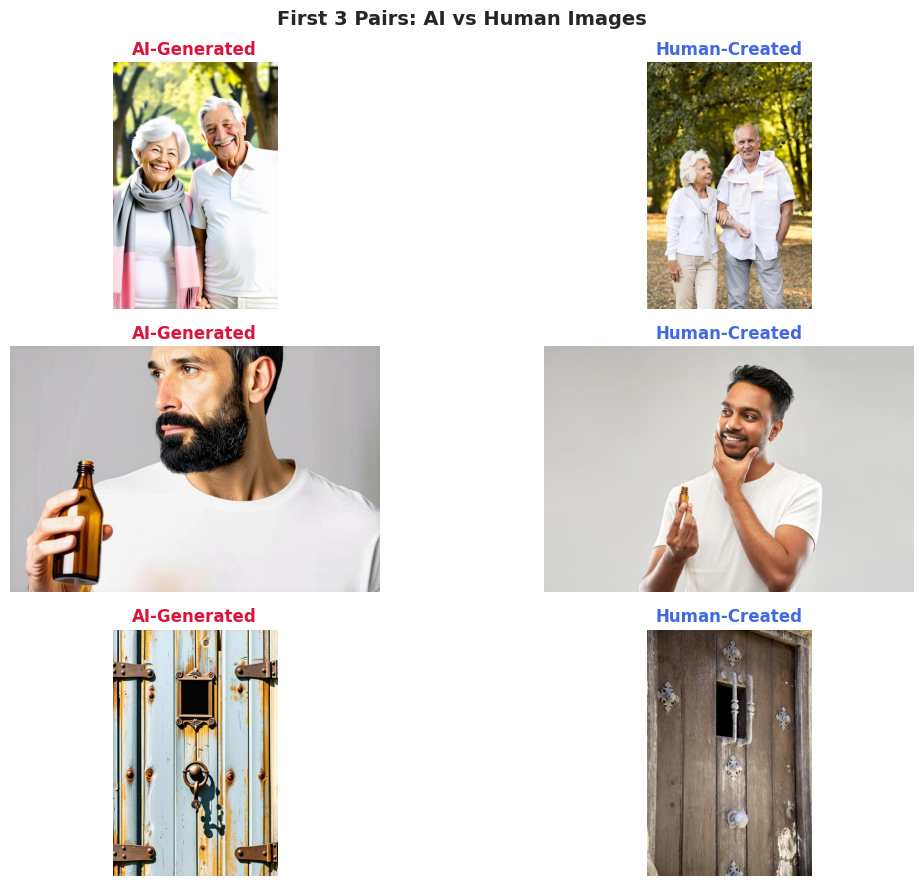

In [ ]:
# Display First 3 Pairs of AI vs Human Images
def show_paired_images():
    """
    Displays the first 3 pairs of images: each AI-generated image placed next to its corresponding human-created image.
    """
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows, 2 columns

    # Select first 3 AI-Human pairs
    ai_images = df[df["label"] == 1].head(3)["file_name"].values  # First 3 AI images (Label 1)
    human_images = df[df["label"] == 0].head(3)["file_name"].values  # First 3 Human images (Label 0)

    for i in range(3):
        ai_img = Image.open(ai_images[i])  # Load AI image
        human_img = Image.open(human_images[i])  # Load Human image

        # AI-generated image (Left)
        axes[i, 0].imshow(ai_img)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("AI-Generated", fontsize=12, fontweight="bold", color="crimson")

        # Human-created image (Right)
        axes[i, 1].imshow(human_img)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Human-Created", fontsize=12, fontweight="bold", color="royalblue")

    plt.suptitle("First 3 Pairs: AI vs Human Images", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Show the first 3 pairs of images
show_paired_images()

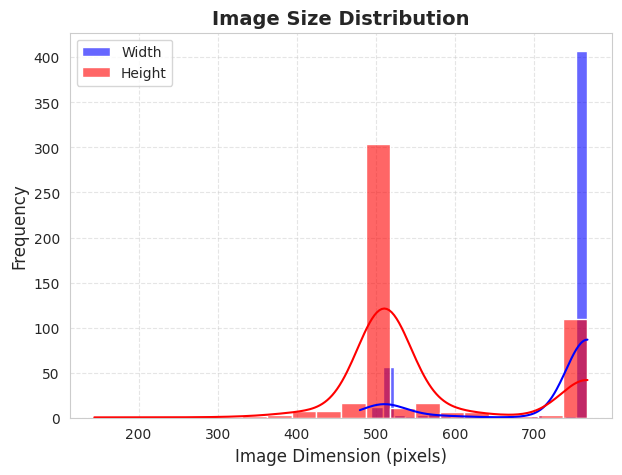

In [ ]:
# Image Size Distribution Plot
image_shapes = []

# Sample 500 images for efficiency
sampled_images = df["file_name"].sample(500, random_state=42)

for img_path in sampled_images:
    try:
        img = Image.open(img_path).convert("RGB")  # Ensure image is in RGB mode
        image_shapes.append(img.size)  # (width, height)
    except Exception as e:
        print(f"Error loading image: {img_path} | {e}")

# Convert to DataFrame for visualization
image_sizes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])

# Plot image size distribution
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

sns.histplot(image_sizes_df["Width"], bins=20, color="blue", label="Width", kde=True, alpha=0.6)
sns.histplot(image_sizes_df["Height"], bins=20, color="red", label="Height", kde=True, alpha=0.6)

plt.xlabel("Image Dimension (pixels)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Image Size Distribution", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Add grid lines

plt.show()

In [ ]:
print("Minimum width: ", image_sizes_df["Width"].min())
print("Maximum width: ", image_sizes_df["Width"].max())
print("Minimum height: ", image_sizes_df["Height"].min())
print("Maximum height: ", image_sizes_df["Height"].max())

Minimum width:  480
Maximum width:  768
Minimum height:  144
Maximum height:  768


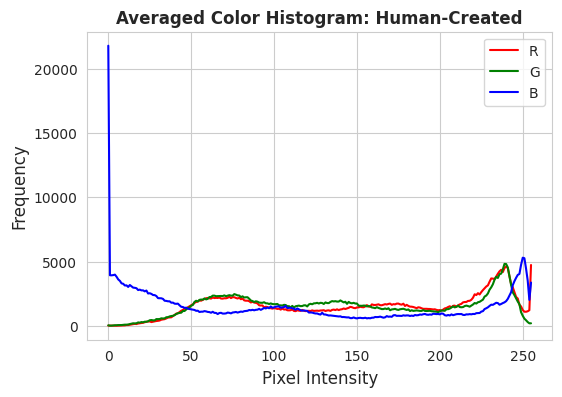

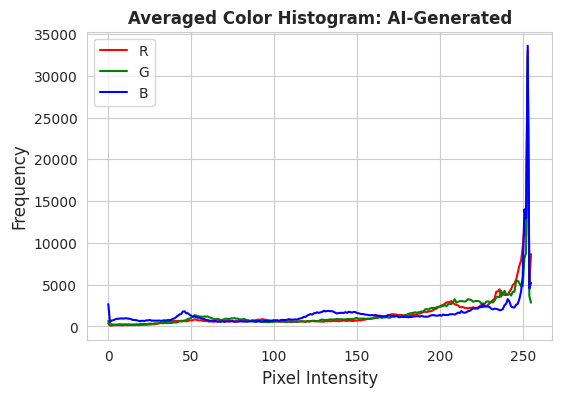

In [ ]:
# Color Histogram Visualization
def plot_color_histogram(image_path, title):
    """
    Plots RGB color histogram for a given image.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    colors = ("r", "g", "b")
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        sns.lineplot(x=np.arange(256), y=hist.flatten(), color=col, label=col.upper())

    plt.title(f"Averaged Color Histogram: {title}", fontsize=12, fontweight="bold")
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.show()

# Show color histogram of the first Human-created image (Label 0)
human_image_path = df[df["label"] == 0]["file_name"].iloc[0]  # Label 0 = Human
plot_color_histogram(human_image_path, "Human-Created")

# Show color histogram of the first AI-generated image (Label 1)
ai_image_path = df[df["label"] == 1]["file_name"].iloc[0]  # Label 1 = AI
plot_color_histogram(ai_image_path, "AI-Generated")

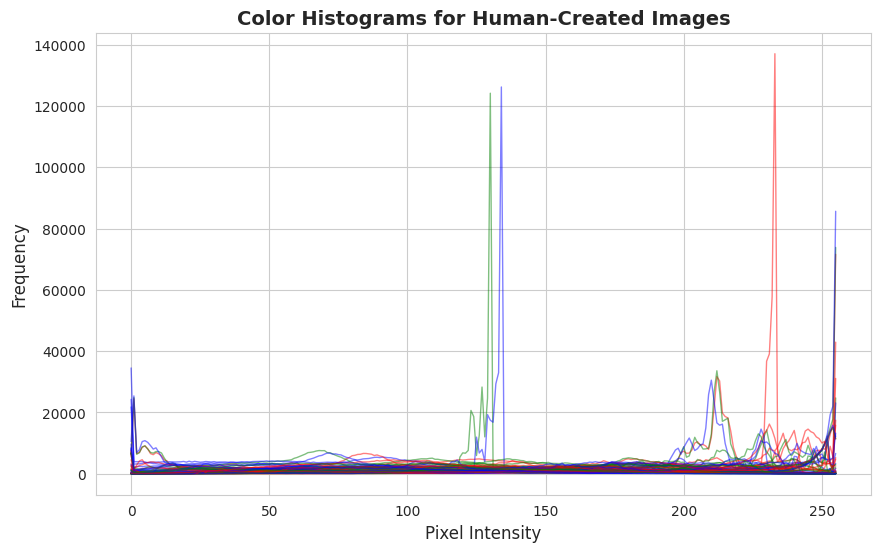

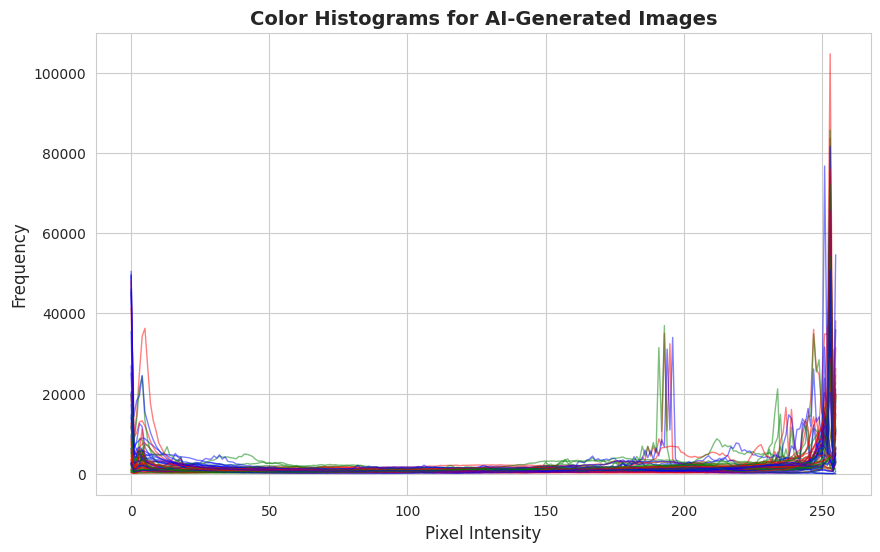

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#  Function to plot color histograms for multiple images (overlay each one)
def plot_overlayed_histograms(image_paths, title, color_labels=("r", "g", "b")):
    """
    Plots RGB color histograms for multiple images, overlaying each image’s histogram.
    """
    plt.figure(figsize=(10, 6))

    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot histogram for each image (overlayed)
        for i, col in enumerate(color_labels):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            sns.lineplot(x=np.arange(256), y=hist.flatten(), color=col, alpha=0.5, linewidth=1)  # Lower alpha for visibility

    plt.title(f"Color Histograms for {title}", fontsize=14, fontweight="bold")
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

# Select 20 AI-generated images and 20 Human-created images
num_samples = 20
human_image_paths = df[df["label"] == 0]["file_name"].iloc[:num_samples].tolist()  # Label 0 = Human
ai_image_paths = df[df["label"] == 1]["file_name"].iloc[:num_samples].tolist()  # Label 1 = AI

# Plot overlayed histograms for Human-created images
plot_overlayed_histograms(human_image_paths, "Human-Created Images")

# Plot overlayed histograms for AI-generated images
plot_overlayed_histograms(ai_image_paths, "AI-Generated Images")

In [ ]:
# transform = A.Compose([
#     A.Resize(224, 224),                     # Resize to 224x224
#     A.HorizontalFlip(p=0.5),                 # Randomly flip images horizontally
#     A.RandomRotate90(p=0.5),                 # Random rotation (90-degree increments)
#     A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
#     ToTensorV2()                             # Convert to PyTorch Tensor
# ])

# # Function to preprocess a single image
# def preprocess_image(image_path):
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
#     augmented = transform(image=image)              # Apply transformations
#     return augmented["image"]

# # Preprocess all images in dataset
# preprocessed_images = []
# labels = []

# # Iterate through dataset and apply preprocessing
# for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Preprocessing Images"):
#     image_path = row["file_name"]
#     label = row["label"]

#     preprocessed_img = preprocess_image(image_path)  # Apply preprocessing
#     preprocessed_images.append(preprocessed_img)
#     labels.append(label)

# #  Convert lists to NumPy arrays
# X = np.stack(preprocessed_images)  # Image tensor
# y = np.array(labels)  # Labels

# # Print dataset shape
# print(f"Processed dataset shape: {X.shape}, Labels shape: {y.shape}")

In [ ]:
# Show me the power

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

def center_crop(img, size):
    h, w = img.shape[:2]
    cw, ch = size
    # reflect‑pad if too small
    pad_vert = max(ch - h, 0)
    pad_horz = max(cw - w, 0)
    if pad_vert or pad_horz:
        top = pad_vert // 2
        bottom = pad_vert - top
        left = pad_horz // 2
        right = pad_horz - left
        img = cv2.copyMakeBorder(img, top, bottom, left, right,
                                 cv2.BORDER_REFLECT_101)
        h, w = img.shape[:2]
    # central crop
    cx, cy = w//2, h//2
    x0 = cx - cw//2; x1 = x0 + cw
    y0 = cy - ch//2; y1 = y0 + ch
    return img[y0:y1, x0:x1]

def highpass(img, sigma=3):
    """ img: float32 gray. returns zero‑mean highpass. """
    blur = gaussian_filter(img, sigma=sigma)
    return img - blur

def make_2d_hann(h, w):
    """ separable 2D Hann window """
    wy = np.hanning(h)[:,None]
    wx = np.hanning(w)[None,:]
    return wy * wx

def average_log_spectrum(logmags, *,
                         crop_size=(224,224),
                         sigma=3,
                         window=True):
    acc = None
    for logmag in logmags:
        # logmag = compute_logmag(p, crop_size=crop_size, sigma=sigma, window=window)
        acc = logmag if acc is None else acc + logmag

    avg = acc / len(image_paths)
    return avg

def compute_logmag(img_path, *,
                    crop_size=(224,224),
                   sigma=3,
                   window=True):
    # read & preprocess
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = center_crop(img, crop_size)
    hp = highpass(img, sigma=sigma)
    if window:
        win = make_2d_hann(*hp.shape)
        hp = hp * win
    # FFT → log‑mag
    F = np.fft.fftshift(np.fft.fft2(hp))
    logmag = np.log1p(np.abs(F))
    return logmag

def joint_normalize(A, B):
    vmin = min(A.min(), B.min())
    vmax = max(A.max(), B.max())
    A2 = (A - vmin) / (vmax - vmin)
    B2 = (B - vmin) / (vmax - vmin)
    return A2, B2

def radial_profile(img, nbins=100):
    """Compute radial average of `img` around its center."""
    h, w = img.shape
    cy, cx = (h//2, w//2)
    Y, X = np.ogrid[:h, :w]
    R = np.hypot(X-cx, Y-cy)
    # bin by integer radius
    r_i = R.astype(np.int32)
    max_r = min(cx, cy, nbins)
    rad_mean = np.bincount(r_i.ravel(), img.ravel(), minlength=max_r+1)
    rad_count = np.bincount(r_i.ravel(), minlength=max_r+1)
    radial_prof = rad_mean[:max_r] / (rad_count[:max_r] + 1e-8)
    return radial_prof

def plot_2d(A, title):
    plt.figure(figsize=(6,6))
    plt.imshow(A, cmap='viridis', origin='lower')
    plt.title(title)
    plt.axis('off')

def plot_radial(r0, r1):
    freqs = np.arange(len(r0))
    plt.figure(figsize=(6,4))
    plt.plot(freqs, r0, label='real (0)')
    plt.plot(freqs, r1, label='AI (1)')
    plt.xlabel('Spatial frequency (px)')
    plt.ylabel('Avg log‑power')
    plt.legend()



In [ ]:
specs_train = np.load("train_specs.npy", mmap_mode="r")    # shape [N, H, W]
specs_test = np.load("test_specs.npy", mmap_mode="r")  # shape [N, H, W]
print(specs_train.shape, specs_test.shape)

(79950, 224, 224) (5540, 224, 224)


In [ ]:
np.save("train_specs.npy", specs_train.astype(np.float32))
np.save("test_specs.npy", specs_test.astype(np.float32))

In [ ]:
train_paths = train_df['file_name'].tolist()
test_paths = test_df['id'].tolist()

N = len(train_paths)
H, W = 224, 224
specs_train = np.zeros((N, H, W), dtype=np.float32)

N = len(test_paths)
specs_test = np.zeros((N, H, W), dtype=np.float32)

# — loop and fill —
for i, p in enumerate(tqdm(train_paths, desc="Precomputing training spectra")):
    specs_train[i] = compute_logmag(p, crop_size=(H,W), sigma=3, window=True)

for i, p in enumerate(tqdm(test_paths, desc="Precomputing testing spectra")):
    specs_test[i] = compute_logmag(p, crop_size=(H,W), sigma=3, window=True)

# — save to disk —
np.save("train_specs.npy", specs_train.astype(np.float16))
np.save("test_specs.npy", specs_test.astype(np.float32))

Precomputing testing spectra: 100%|██████████| 5540/5540 [03:32<00:00, 26.09it/s]


In [ ]:
print(specs_train.shape, specs_test.shape)

(79950, 224, 224) (5540, 224, 224)


In [ ]:
def streaming_mean_std(mm_array, chunk_size=500):
    count = 0
    mean = 0.0
    M2 = 0.0

    N = mm_array.shape[0]
    for i in range(0, N, chunk_size):
        chunk = mm_array[i:i+chunk_size].astype(np.float32)
        # mask out any infinities
        chunk = chunk[np.isfinite(chunk)]
        if chunk.size == 0:
            continue
        # flatten to 1D
        flat = chunk.ravel()
        n = flat.size
        mean_chunk = flat.mean()
        var_chunk  = flat.var()

        # Welford update
        delta = mean_chunk - mean
        total = count + n
        mean = (mean * count + mean_chunk * n) / total
        M2 += var_chunk * n + delta * delta * (count * n) / total
        count = total

    std = np.sqrt(M2 / count)
    return mean, std

spec_train_mean, spec_train_std = streaming_mean_std(specs_train)

In [ ]:
print(spec_train_mean, spec_train_std)
# 5.9098186 1.4327419

5.9098186 1.4327419


In [ ]:
spec_test_mean, spec_test_std = streaming_mean_std(specs_test)

In [ ]:
print(spec_test_mean, spec_test_std)
# 5.7614927 1.3917245

5.7614927 1.3917245


In [ ]:
# --- USAGE ----------------------------------------------------------

# paths1 = train_df[train_df["label"]==1].sample(2000, random_state=42)['file_name']
# paths0 = train_df[train_df["label"]==0].sample(2000, random_state=42)['file_name']
logmags1 = specs_train[train_df["label"]==1].sample(2000, random_state=42)
logmags0 = specs_train[train_df["label"]==0].sample(2000, random_state=42)

# compute class‑averages
A1 = average_log_spectrum(logmags1, crop_size=(224,224), sigma=3, window=True)
A0 = average_log_spectrum(logmags0, crop_size=(224,224), sigma=3, window=True)

# # normalize them together for fair color‑scaling
D1, D0 = joint_normalize(A1, A0)

r0, r1 = radial_profile(A0, nbins=112), radial_profile(A1, nbins=112)

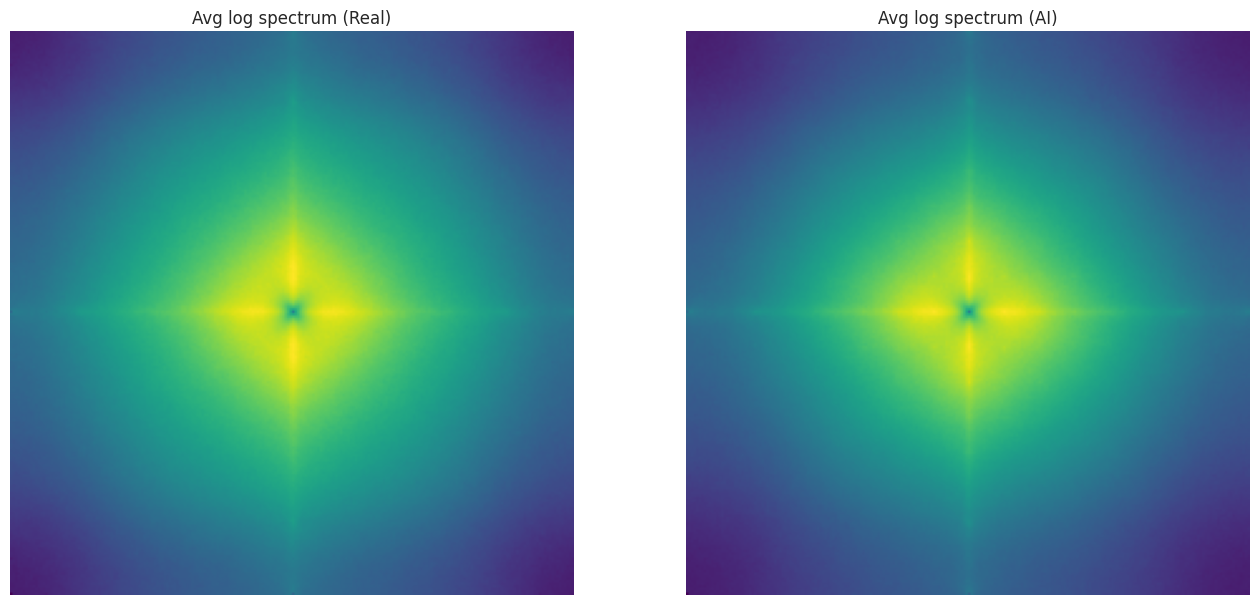

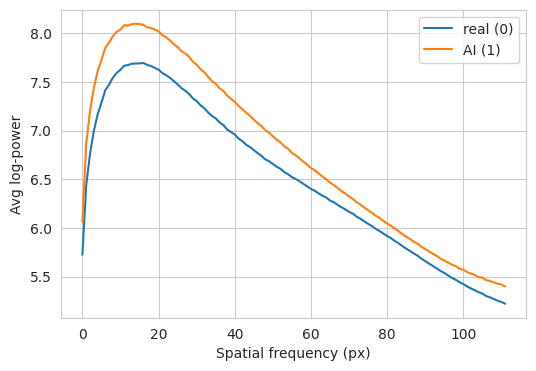

In [ ]:
# show the 2D spectra

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(D0, cmap="viridis", origin="lower")
axes[0].set_title("Avg log spectrum (Real)")
axes[0].axis('off')

axes[1].imshow(D1, cmap="viridis", origin="lower")
axes[1].set_title("Avg log spectrum (AI)")
axes[1].axis('off')

plt.show()

# compute & plot radial 1D profiles

plot_radial(r0, r1)

plt.show()

In [ ]:
# prompt: initialize arrays spect_features, edge_features, and hog_features by reading data from spect_features.json, edge_features.json, hog_features.json

# This is to make it easier to rerun the notebook, since you don't have to run the get_spectral_features
# process on every single sample every time you want to run the notebook.
import json
import numpy as np
spect_features, spect_test_features = [], []

# Load features from JSON files
with open('spect_features.json', 'r') as f:
    spect_features = np.array(json.load(f))

with open('spect_test_features.json', 'r') as f:
    spect_test_features = np.array(json.load(f))

print(f"Spect Features Shape: {spect_features.shape}")  # (num_samples, 112)

Spect Features Shape: (79950, 112)


In [ ]:
# Get spectral features for each sample in the training and testing set

train_X, train_y = train_df['file_name'], train_df['label']
print(train_X.shape, train_y.shape)

def load_and_preprocess(img_path, crop_size=(224, 224)):
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
  img = center_crop(img, crop_size)
  return img

def get_spectral_features(paths, window=True):
  spect_features = []
  # logmags = []
  for img_path in paths:
    logmag = compute_logmag(img_path, crop_size=(224,224), sigma=3, window=window)
    # logmags.append(logmag)
    r    = radial_profile(logmag, nbins=112)
    spect_features.append(r)        # length‑112 vector
  return np.array(spect_features)


(79950,) (79950,)


In [ ]:
if len(spect_features) == 0:
  spect_features = get_spectral_features(train_X)
if len(spect_features) == 0:
  spect_test_features = get_spectral_features(test_df['id'])
spect_features.shape

(79950, 112)

In [ ]:
spect_features.shape

(79950, 112)

In [ ]:
# prompt: export spect_features to .json file

import json

# Export spect_features to a JSON file
with open('spect_features.json', 'w') as f:
    json.dump(spect_features.tolist(), f)

with open('spect_test_features.json', 'w') as f:
    json.dump(spect_test_features.tolist(), f)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize features for better t-SNE performance
spect_sample = spect_features[:2000]
print(spect_sample.shape)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(spect_sample)
features_reduced = PCA(n_components=50).fit_transform(features_scaled)
features_tsne = TSNE(n_components=2, random_state=42).fit_transform(features_reduced)



(2000, 112)


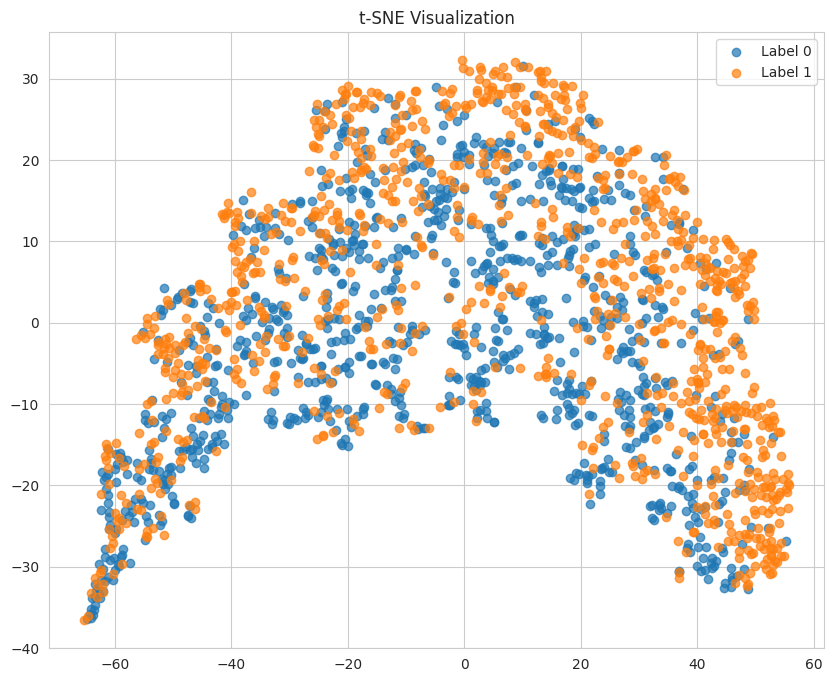

In [ ]:
# Plot the t-SNE result with color-coding for class labels
train_X, train_y = train_df['file_name'], train_df['label']
plt.figure(figsize=(10, 8))
# Scatter plot for each class
label_samples = train_y[:2000]
for class_value in np.unique(label_samples):
    idx = label_samples == class_value
    plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1],
                label=f'Label {class_value}', alpha=0.7)

plt.title('t-SNE Visualization')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


X_train, X_val, y_train, y_val = train_test_split(spect_features, train_y, test_size=0.2, random_state=42)

X_t = torch.from_numpy(X_train).float()
y_t = torch.from_numpy(y_train.values).long()
val_t = torch.from_numpy(X_val).float()
val_l = torch.from_numpy(y_val.values).long()

train_ds = TensorDataset(X_t, y_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

val_ds = TensorDataset(val_t, val_l)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(63960, 112) (63960,)
(15990, 112) (15990,)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import timm

In [ ]:
import torch.nn as nn

class SpecMLP(nn.Module):
    def __init__(self,
                 input_dim=112,
                 hidden_dims=(256,128),
                 dropout=0.2,
                 use_batchnorm=True):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [ ]:
class RadialDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
    def __getitem__(self, idx):
      r = self.radial_profiles[idx]              # torch.Tensor [112]
      if self.spec_transforms:
          r = self.spec_transforms(r)            # jitter, dropout, warp…
      return r, int(self.labels[idx])

In [ ]:
import torch
import torch.nn.functional as F

def mixup_collate(batch, alpha=0.4, num_classes=2):
    xs = torch.stack([item[0] for item in batch], dim=0)            # [B, L]
    ys = torch.tensor([item[1] for item in batch], dtype=torch.long) # [B]
    # one-hot
    Ys = F.one_hot(ys, num_classes).float()                         # [B, num_classes]

    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(len(xs))
    x2, y2 = xs[idx], Ys[idx]

    x_mix = lam * xs + (1 - lam) * x2
    y_mix = lam * Ys + (1 - lam) * y2

    return x_mix, y_mix

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_f1s, fold):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(18, 5))


    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss - Fold {fold}")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, [acc.cpu().numpy() for acc in train_accuracies], label='Train Acc')
    plt.plot(epochs_range, val_accuracies, label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy - Fold {fold}")
    plt.legend()

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, val_f1s, label='Val F1')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title(f"Validation F1 Score - Fold {fold}")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Let's go even further beyond and derive features from the portion of spect_features
# where the difference between AI and real image is highest

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

radial_np = np.array(spect_features)

# compute band stats
def band_stats(r, lo=10, hi=30):
    band = r[lo:hi]
    return {
        'band_mean':     band.mean(),
        'band_std':      band.std(),
        'band_max':      band.max(),
        'band_centroid': (np.arange(lo,hi)*band).sum() / (band.sum()+1e-8)
    }

# list of dicts → DataFrame of shape (N,4)
df_band = pd.DataFrame(band_stats(r) for r in radial_np)

def spectral_entropy(r):
    p = r.clip(min=0)
    p = p / (p.sum()+1e-8)
    return - (p * np.log(p + 1e-12)).sum()

df_band['entropy'] = [spectral_entropy(r) for r in radial_np]

def compute_spectral_rolloff(radial_profile, roll_percent=0.85):
    total_energy = np.sum(radial_profile)
    cumulative_energy = 0
    roll_off_frequency = 0

    for i, energy in enumerate(radial_profile):
        cumulative_energy += energy
        if cumulative_energy >= total_energy * roll_percent:
            roll_off_frequency = i
            break

    return roll_off_frequency

df_band['roll_off'] = [compute_spectral_rolloff(r) for r in radial_np]



# concatenate into one big feature matrix
X_np = np.hstack([ radial_np, df_band.values ])

In [ ]:
X_np.shape

(79950, 118)

In [ ]:
radial_np_test = np.array(spect_test_features)
df_band_test = pd.DataFrame(band_stats(r) for r in radial_np_test)
df_band_test['entropy'] = [spectral_entropy(r) for r in radial_np_test]
df_band_test['roll_off'] = [compute_spectral_rolloff(r) for r in radial_np_test]
X_np_test = np.hstack([ radial_np_test, df_band_test.values ])
X_np_test.shape

(5540, 118)

In [ ]:
import torch
import torch.nn.functional as F
import random

class SpectralJitter:
    """Add Gaussian noise to each bin"""
    def __init__(self, sigma=0.02):
        self.sigma = sigma

    def __call__(self, x):
        # x: Tensor [C, L] or [L]
        return x + torch.randn_like(x) * self.sigma


class SpectralDropout:
    """Zero out a random fraction of bins"""
    def __init__(self, p=0.1):
        self.p = p

    def __call__(self, x):
        mask = (torch.rand_like(x) > self.p).float()
        return x * mask


class FrequencyWarp:
    """Randomly stretch/compress the 1D axis and re‑interpolate back to length L"""
    def __init__(self, scale_range=(0.9, 1.1)):
        self.scale_range = scale_range

    def __call__(self, x):
        L = x.shape[-1]
        scale = random.uniform(*self.scale_range)
        # build a source grid [0,1] → target grid
        orig_pts = torch.linspace(0, 1, L, device=x.device)
        warped_pts = (orig_pts - 0.5) * scale + 0.5
        # clamp into [0,1]
        warped_pts = warped_pts.clamp(0, 1)
        # map back to indices [0, L-1]
        idx = warped_pts * (L - 1)
        # use 1‑D linear sampling
        x = x.unsqueeze(0).unsqueeze(0)  # [1,1,L]
        warped = F.grid_sample(
            x,
            idx.view(1,1,-1,1) * 2 - 1,    # grid_sample expects coords in [-1,+1]
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )
        return warped.view(-1)


from torchvision import transforms
spec_transforms = transforms.Compose([
    SpectralJitter(sigma=0.03),
    SpectralDropout(p=0.1),
    FrequencyWarp(scale_range=(0.95,1.05)),
])

In [ ]:
def get_scheduler(optimizer, name):
    if name == 'cosine':
        return torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-5)
    elif name == 'step':
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif name == 'plateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    else:
        return None


In [ ]:
epochs = 10
# epochs_without_improvement = 0
patience = 2
overall_best_f1 = 0.0
results = {}
overall_best_config = ""
pos_weight = 0.5
def train_fold(train_idx, val_idx, fold, config):
    global overall_best_f1, overall_best_config  # Declare as global
    # config is a dict containing all hyperparams
    model = SpecMLP(
        input_dim   = config['input_dim'],
        hidden_dims = config['hidden_dims'],
        dropout     = config['dropout'],
        # use_batchnorm = config['use_batchnorm']
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config['lr'],
        weight_decay=0.0
    )
    scheduler = get_scheduler(optimizer, config['scheduler'])
    # pw = torch.tensor([pos_weight]).to(device)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.KLDivLoss(reduction='batchmean')


    epochs   = 10
    patience = 2
    batch_size = 64

    # split tensors
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]

    X_train = X_train.cpu().numpy()
    X_val = X_val.cpu().numpy()

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Convert back to PyTorch tensors after scaling
    X_train = torch.from_numpy(X_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_train = y_train
    y_val = y_val


    # dataloaders
    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val,   y_val)
    train_loader = DataLoader(
        train_ds,
        batch_size=64,
        shuffle=True,
        collate_fn=lambda b: mixup_collate(b, alpha=0.3),
        num_workers=4,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=64,
        shuffle=False,
        collate_fn=lambda b: mixup_collate(b, alpha=0.3),
        num_workers=4,
    )

    # Initialize lists to store loss, accuracy, and F1 scores
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1s = []


    val_loss = 0.0
    val_acc = 0.0

    best_f1 = 0.0
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Train the model
    for epoch in range(epochs):

        epoch_loss = 0.0
        epoch_accuracy = 0.0
        epoch_f1 = 0.0

        # training
        model.train()
        for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            logits = model(data)
            log_probs = F.log_softmax(logits, dim=1)  # [B,2]
            loss = criterion(F.log_softmax(logits, dim=1), label)
            # label = label.unsqueeze(1).float()  # Add a dimension and convert to float

            # loss = criterion(logits[:,1], label.squeeze(1))
            # loss = criterion(logits, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_accuracy += (logits.argmax(dim=1) == label.argmax(dim=1)).float().mean()

        epoch_loss /= len(train_loader)
        epoch_accuracy /= len(train_loader)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # validation
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                # data, label = data.to(device), label.to(device)
                data = data.to(device, non_blocking=True)
                label = label.to(device, non_blocking=True)
                logits = model(data)
                # loss = criterion(logits[:,1], label.float())
                loss = criterion(F.log_softmax(logits, dim=1), label)
                # loss = criterion(logits, label)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                target_labels = label.argmax(dim=1)
                val_acc += (preds == target_labels).float().mean().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(target_labels.cpu().numpy())


        f1 = f1_score(all_labels, all_preds)
        print(f"Fold {fold}, Epoch {epoch}, Val F1 = {f1:.4f}")


        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Calculate F1 Score
        val_f1 = f1_score(all_labels, all_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)


        # Print progress
        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
        )

        config_key = f"spect_mlp_fold{fold}_lr{config['lr']}_dim{config['hidden_dims']}"
        # Early Stopping Logic
        # Check improvement
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f"best_weights_{config_key}.pth")
            torch.save(model, f"best_model_{config_key}.pt")
            print(f"Model saved with best F1: {best_f1:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No improvement at epoch {epoch+1}")

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        if epochs_without_improvement >= patience:
            print(f"Stopped early at epoch {epoch+1}")
            break
        model.eval()

    results[config_key] = {
        "best_f1": best_f1,
        "fold": fold,
        "model": "spect_mlp"
    }

    if best_f1 > overall_best_f1:
        overall_best_f1 = best_f1
        overall_best_config = config_key


    with open("model_f1_results.json", "w") as f:
        json.dump(results, f, indent=4)




    if best_f1 > overall_best_f1:
        overall_best_f1 = best_f1
        overall_best_config = config_key

    print(f"\n Best config so far: {overall_best_config} with F1 = {overall_best_f1:.4f}")
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_f1s, fold)
    return best_f1


=== Running config 1/6: {'lr': 0.0003, 'hidden_dims': (128, 64), 'scheduler': 'cosine', 'dropout': 0.1, 'input_dim': 118, 'epochs': 10}


Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 140.00it/s]


Fold 1, Epoch 0, Val F1 = 0.7738
Epoch [1/10] Train Loss: 0.3968 | Train Acc: 0.7491 | Val Loss: 0.3692 | Val Acc: 0.7807 | Val F1: 0.7738
Model saved with best F1: 0.7738


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 142.97it/s]


Fold 1, Epoch 1, Val F1 = 0.7686
Epoch [2/10] Train Loss: 0.3696 | Train Acc: 0.7736 | Val Loss: 0.3505 | Val Acc: 0.7827 | Val F1: 0.7686
No improvement at epoch 2


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 139.43it/s]


Fold 1, Epoch 2, Val F1 = 0.7880
Epoch [3/10] Train Loss: 0.3650 | Train Acc: 0.7789 | Val Loss: 0.3499 | Val Acc: 0.7862 | Val F1: 0.7880
Model saved with best F1: 0.7880


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 141.77it/s]


Fold 1, Epoch 3, Val F1 = 0.7888
Epoch [4/10] Train Loss: 0.3561 | Train Acc: 0.7791 | Val Loss: 0.3451 | Val Acc: 0.7877 | Val F1: 0.7888
Model saved with best F1: 0.7888


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 141.09it/s]


Fold 1, Epoch 4, Val F1 = 0.7893
Epoch [5/10] Train Loss: 0.3498 | Train Acc: 0.7800 | Val Loss: 0.3533 | Val Acc: 0.7919 | Val F1: 0.7893
Model saved with best F1: 0.7893


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 141.33it/s]


Fold 1, Epoch 5, Val F1 = 0.7895
Epoch [6/10] Train Loss: 0.3513 | Train Acc: 0.7852 | Val Loss: 0.3395 | Val Acc: 0.7932 | Val F1: 0.7895
Model saved with best F1: 0.7895


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 137.99it/s]


Fold 1, Epoch 6, Val F1 = 0.7869
Epoch [7/10] Train Loss: 0.3483 | Train Acc: 0.7877 | Val Loss: 0.3427 | Val Acc: 0.7941 | Val F1: 0.7869
No improvement at epoch 7


Validation Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 142.71it/s]


Fold 1, Epoch 7, Val F1 = 0.7964
Epoch [8/10] Train Loss: 0.3446 | Train Acc: 0.7882 | Val Loss: 0.3380 | Val Acc: 0.7955 | Val F1: 0.7964
Model saved with best F1: 0.7964


Validation Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 143.72it/s]


Fold 1, Epoch 8, Val F1 = 0.7895
Epoch [9/10] Train Loss: 0.3423 | Train Acc: 0.7896 | Val Loss: 0.3333 | Val Acc: 0.7968 | Val F1: 0.7895
No improvement at epoch 9


Validation Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 144.03it/s]


Fold 1, Epoch 9, Val F1 = 0.7902
Epoch [10/10] Train Loss: 0.3423 | Train Acc: 0.7933 | Val Loss: 0.3331 | Val Acc: 0.7919 | Val F1: 0.7902
No improvement at epoch 10
Stopped early at epoch 10

 Best config so far: spect_mlp_fold1_lr0.0003_dim(128, 64) with F1 = 0.7964


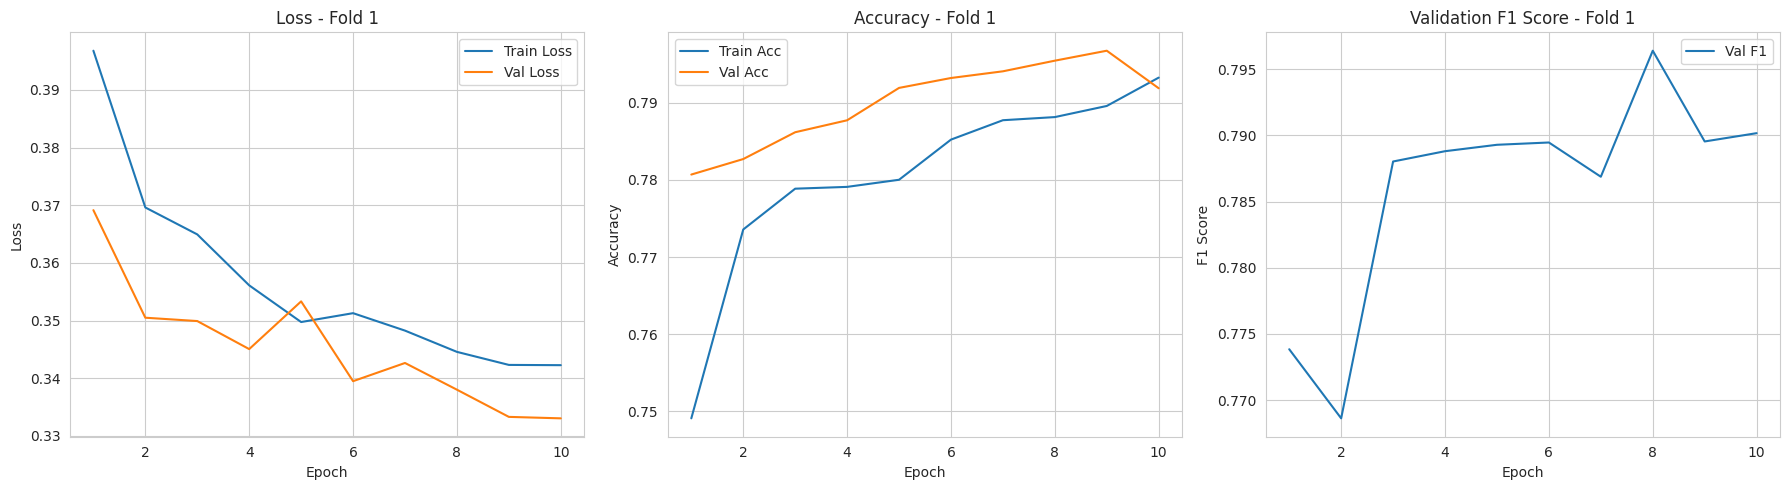

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 141.80it/s]


Fold 2, Epoch 0, Val F1 = 0.7574
Epoch [1/10] Train Loss: 0.3938 | Train Acc: 0.7521 | Val Loss: 0.3548 | Val Acc: 0.7683 | Val F1: 0.7574
Model saved with best F1: 0.7574


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 142.67it/s]


Fold 2, Epoch 1, Val F1 = 0.7689
Epoch [2/10] Train Loss: 0.3687 | Train Acc: 0.7743 | Val Loss: 0.3586 | Val Acc: 0.7745 | Val F1: 0.7689
Model saved with best F1: 0.7689


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 142.99it/s]


Fold 2, Epoch 2, Val F1 = 0.7789
Epoch [3/10] Train Loss: 0.3593 | Train Acc: 0.7780 | Val Loss: 0.3591 | Val Acc: 0.7797 | Val F1: 0.7789
Model saved with best F1: 0.7789


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 144.76it/s]


Fold 2, Epoch 3, Val F1 = 0.7665
Epoch [4/10] Train Loss: 0.3578 | Train Acc: 0.7819 | Val Loss: 0.3450 | Val Acc: 0.7788 | Val F1: 0.7665
No improvement at epoch 4


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 139.73it/s]


Fold 2, Epoch 4, Val F1 = 0.7685
Epoch [5/10] Train Loss: 0.3542 | Train Acc: 0.7837 | Val Loss: 0.3486 | Val Acc: 0.7823 | Val F1: 0.7685
No improvement at epoch 5
Stopped early at epoch 5

 Best config so far: spect_mlp_fold1_lr0.0003_dim(128, 64) with F1 = 0.7964


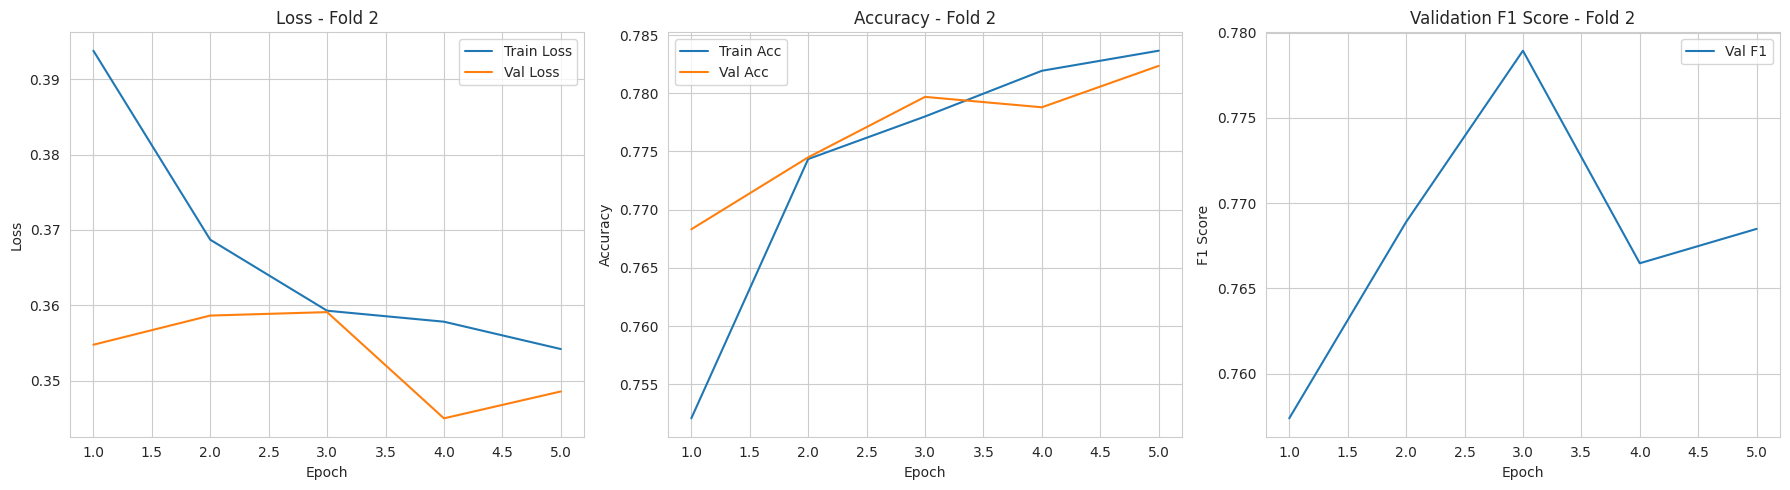

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 144.13it/s]


Fold 3, Epoch 0, Val F1 = 0.7664
Epoch [1/10] Train Loss: 0.3921 | Train Acc: 0.7505 | Val Loss: 0.3559 | Val Acc: 0.7766 | Val F1: 0.7664
Model saved with best F1: 0.7664


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 139.62it/s]


Fold 3, Epoch 1, Val F1 = 0.7815
Epoch [2/10] Train Loss: 0.3685 | Train Acc: 0.7697 | Val Loss: 0.3437 | Val Acc: 0.7912 | Val F1: 0.7815
Model saved with best F1: 0.7815


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 146.32it/s]


Fold 3, Epoch 2, Val F1 = 0.7847
Epoch [3/10] Train Loss: 0.3626 | Train Acc: 0.7756 | Val Loss: 0.3425 | Val Acc: 0.7858 | Val F1: 0.7847
Model saved with best F1: 0.7847


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 144.18it/s]


Fold 3, Epoch 3, Val F1 = 0.7831
Epoch [4/10] Train Loss: 0.3553 | Train Acc: 0.7789 | Val Loss: 0.3361 | Val Acc: 0.7889 | Val F1: 0.7831
No improvement at epoch 4


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 143.20it/s]


Fold 3, Epoch 4, Val F1 = 0.7902
Epoch [5/10] Train Loss: 0.3551 | Train Acc: 0.7816 | Val Loss: 0.3317 | Val Acc: 0.7887 | Val F1: 0.7902
Model saved with best F1: 0.7902


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 140.35it/s]


Fold 3, Epoch 5, Val F1 = 0.7922
Epoch [6/10] Train Loss: 0.3487 | Train Acc: 0.7825 | Val Loss: 0.3361 | Val Acc: 0.7946 | Val F1: 0.7922
Model saved with best F1: 0.7922


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 143.33it/s]


Fold 3, Epoch 6, Val F1 = 0.7946
Epoch [7/10] Train Loss: 0.3507 | Train Acc: 0.7855 | Val Loss: 0.3319 | Val Acc: 0.7935 | Val F1: 0.7946
Model saved with best F1: 0.7946


Validation Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 140.41it/s]


Fold 3, Epoch 7, Val F1 = 0.7972
Epoch [8/10] Train Loss: 0.3477 | Train Acc: 0.7881 | Val Loss: 0.3315 | Val Acc: 0.7977 | Val F1: 0.7972
Model saved with best F1: 0.7972


Validation Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 142.49it/s]


Fold 3, Epoch 8, Val F1 = 0.7973
Epoch [9/10] Train Loss: 0.3437 | Train Acc: 0.7927 | Val Loss: 0.3307 | Val Acc: 0.7971 | Val F1: 0.7973
Model saved with best F1: 0.7973


Validation Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 143.30it/s]


Fold 3, Epoch 9, Val F1 = 0.7972
Epoch [10/10] Train Loss: 0.3431 | Train Acc: 0.7887 | Val Loss: 0.3347 | Val Acc: 0.8003 | Val F1: 0.7972
No improvement at epoch 10

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


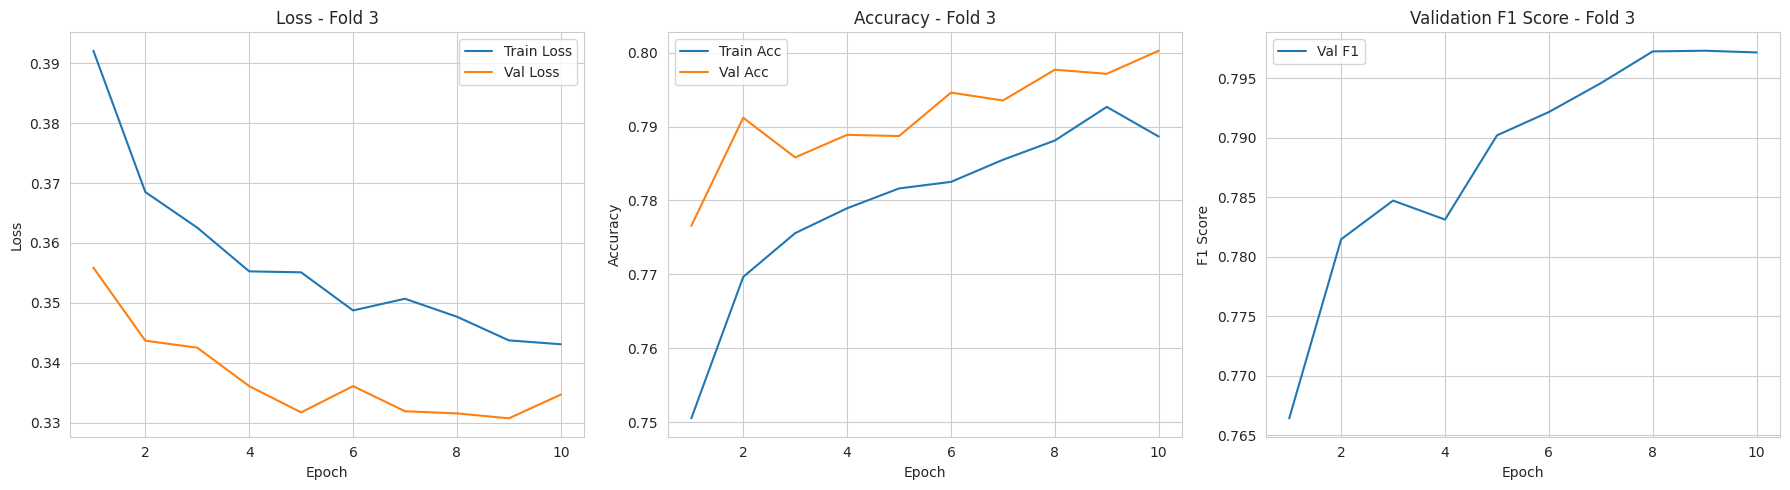

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 145.22it/s]


Fold 4, Epoch 0, Val F1 = 0.7515
Epoch [1/10] Train Loss: 0.3919 | Train Acc: 0.7510 | Val Loss: 0.3576 | Val Acc: 0.7728 | Val F1: 0.7515
Model saved with best F1: 0.7515


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 138.52it/s]


Fold 4, Epoch 1, Val F1 = 0.7797
Epoch [2/10] Train Loss: 0.3697 | Train Acc: 0.7728 | Val Loss: 0.3481 | Val Acc: 0.7836 | Val F1: 0.7797
Model saved with best F1: 0.7797


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 145.11it/s]


Fold 4, Epoch 2, Val F1 = 0.7720
Epoch [3/10] Train Loss: 0.3647 | Train Acc: 0.7748 | Val Loss: 0.3427 | Val Acc: 0.7747 | Val F1: 0.7720
No improvement at epoch 3


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 137.12it/s]


Fold 4, Epoch 3, Val F1 = 0.7797
Epoch [4/10] Train Loss: 0.3544 | Train Acc: 0.7780 | Val Loss: 0.3423 | Val Acc: 0.7764 | Val F1: 0.7797
No improvement at epoch 4
Stopped early at epoch 4

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


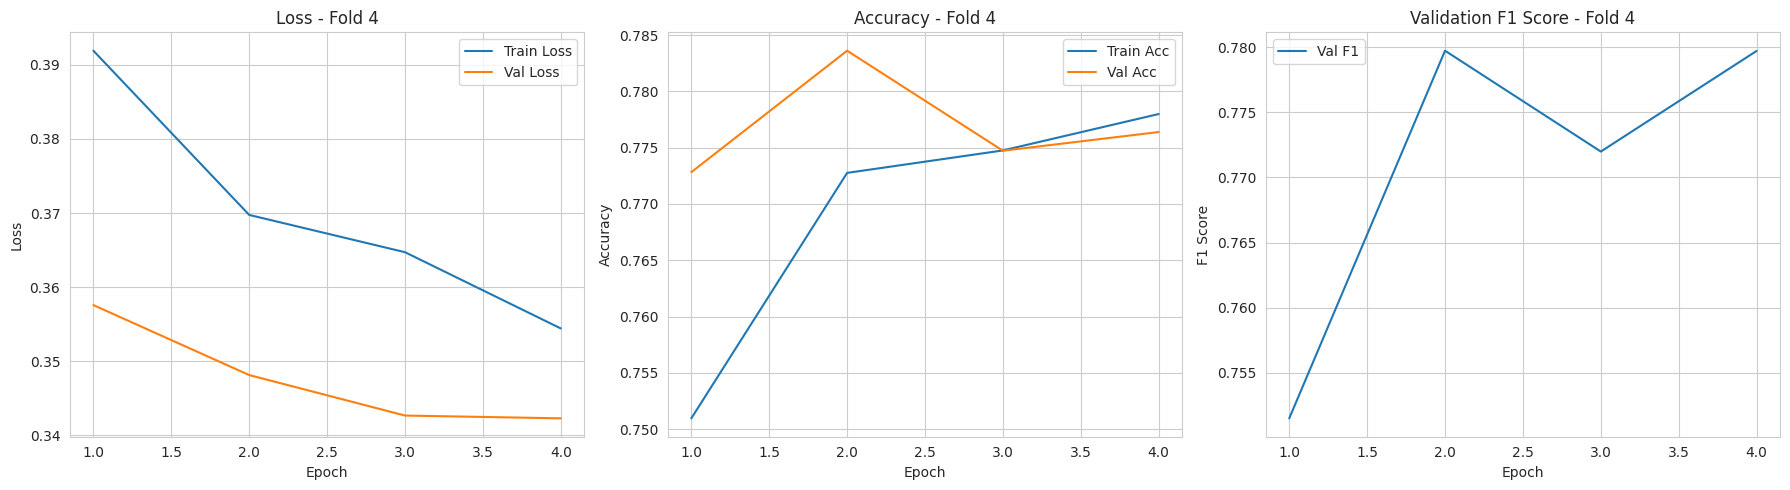

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 142.07it/s]


Fold 5, Epoch 0, Val F1 = 0.7696
Epoch [1/10] Train Loss: 0.3932 | Train Acc: 0.7515 | Val Loss: 0.3606 | Val Acc: 0.7792 | Val F1: 0.7696
Model saved with best F1: 0.7696


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 142.17it/s]


Fold 5, Epoch 1, Val F1 = 0.7894
Epoch [2/10] Train Loss: 0.3750 | Train Acc: 0.7723 | Val Loss: 0.3539 | Val Acc: 0.7971 | Val F1: 0.7894
Model saved with best F1: 0.7894


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 143.44it/s]


Fold 5, Epoch 2, Val F1 = 0.7923
Epoch [3/10] Train Loss: 0.3671 | Train Acc: 0.7752 | Val Loss: 0.3364 | Val Acc: 0.7849 | Val F1: 0.7923
Model saved with best F1: 0.7923


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 138.04it/s]


Fold 5, Epoch 3, Val F1 = 0.7890
Epoch [4/10] Train Loss: 0.3629 | Train Acc: 0.7776 | Val Loss: 0.3499 | Val Acc: 0.7904 | Val F1: 0.7890
No improvement at epoch 4


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 142.40it/s]


Fold 5, Epoch 4, Val F1 = 0.7854
Epoch [5/10] Train Loss: 0.3539 | Train Acc: 0.7770 | Val Loss: 0.3372 | Val Acc: 0.7958 | Val F1: 0.7854
No improvement at epoch 5
Stopped early at epoch 5

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


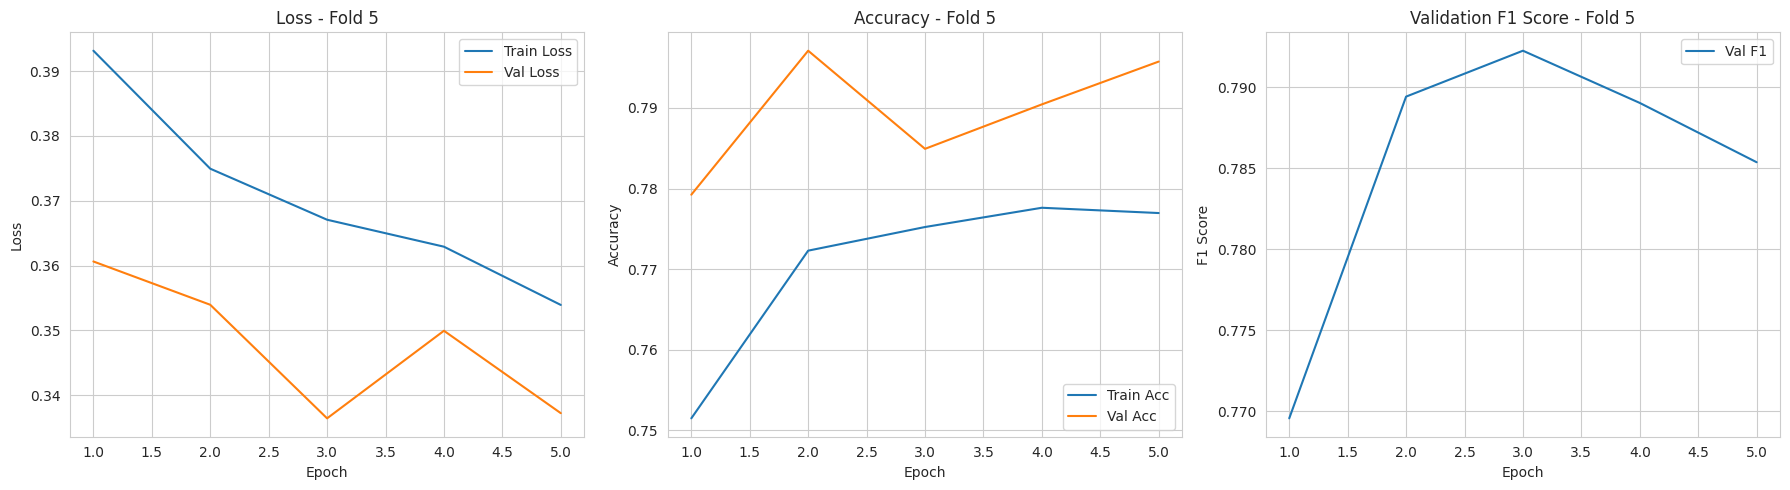

Config 1 mean F1 = 0.7889

=== Running config 2/6: {'lr': 0.0003, 'hidden_dims': (128, 64), 'scheduler': 'cosine', 'dropout': 0.2, 'input_dim': 118, 'epochs': 10}


Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 139.16it/s]


Fold 1, Epoch 0, Val F1 = 0.7653
Epoch [1/10] Train Loss: 0.3967 | Train Acc: 0.7452 | Val Loss: 0.3707 | Val Acc: 0.7691 | Val F1: 0.7653
Model saved with best F1: 0.7653


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 141.62it/s]


Fold 1, Epoch 1, Val F1 = 0.7719
Epoch [2/10] Train Loss: 0.3766 | Train Acc: 0.7678 | Val Loss: 0.3480 | Val Acc: 0.7812 | Val F1: 0.7719
Model saved with best F1: 0.7719


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 139.97it/s]


Fold 1, Epoch 2, Val F1 = 0.7821
Epoch [3/10] Train Loss: 0.3676 | Train Acc: 0.7723 | Val Loss: 0.3487 | Val Acc: 0.7842 | Val F1: 0.7821
Model saved with best F1: 0.7821


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 142.03it/s]


Fold 1, Epoch 3, Val F1 = 0.7829
Epoch [4/10] Train Loss: 0.3624 | Train Acc: 0.7764 | Val Loss: 0.3556 | Val Acc: 0.7804 | Val F1: 0.7829
Model saved with best F1: 0.7829


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 139.08it/s]


Fold 1, Epoch 4, Val F1 = 0.7825
Epoch [5/10] Train Loss: 0.3590 | Train Acc: 0.7802 | Val Loss: 0.3503 | Val Acc: 0.7920 | Val F1: 0.7825
No improvement at epoch 5


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 140.56it/s]


Fold 1, Epoch 5, Val F1 = 0.7869
Epoch [6/10] Train Loss: 0.3531 | Train Acc: 0.7792 | Val Loss: 0.3436 | Val Acc: 0.7894 | Val F1: 0.7869
Model saved with best F1: 0.7869


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 140.31it/s]


Fold 1, Epoch 6, Val F1 = 0.7936
Epoch [7/10] Train Loss: 0.3516 | Train Acc: 0.7831 | Val Loss: 0.3441 | Val Acc: 0.7949 | Val F1: 0.7936
Model saved with best F1: 0.7936


Validation Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 143.88it/s]


Fold 1, Epoch 7, Val F1 = 0.7923
Epoch [8/10] Train Loss: 0.3531 | Train Acc: 0.7831 | Val Loss: 0.3401 | Val Acc: 0.7937 | Val F1: 0.7923
No improvement at epoch 8


Validation Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 138.32it/s]


Fold 1, Epoch 8, Val F1 = 0.7872
Epoch [9/10] Train Loss: 0.3470 | Train Acc: 0.7872 | Val Loss: 0.3441 | Val Acc: 0.7927 | Val F1: 0.7872
No improvement at epoch 9
Stopped early at epoch 9

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


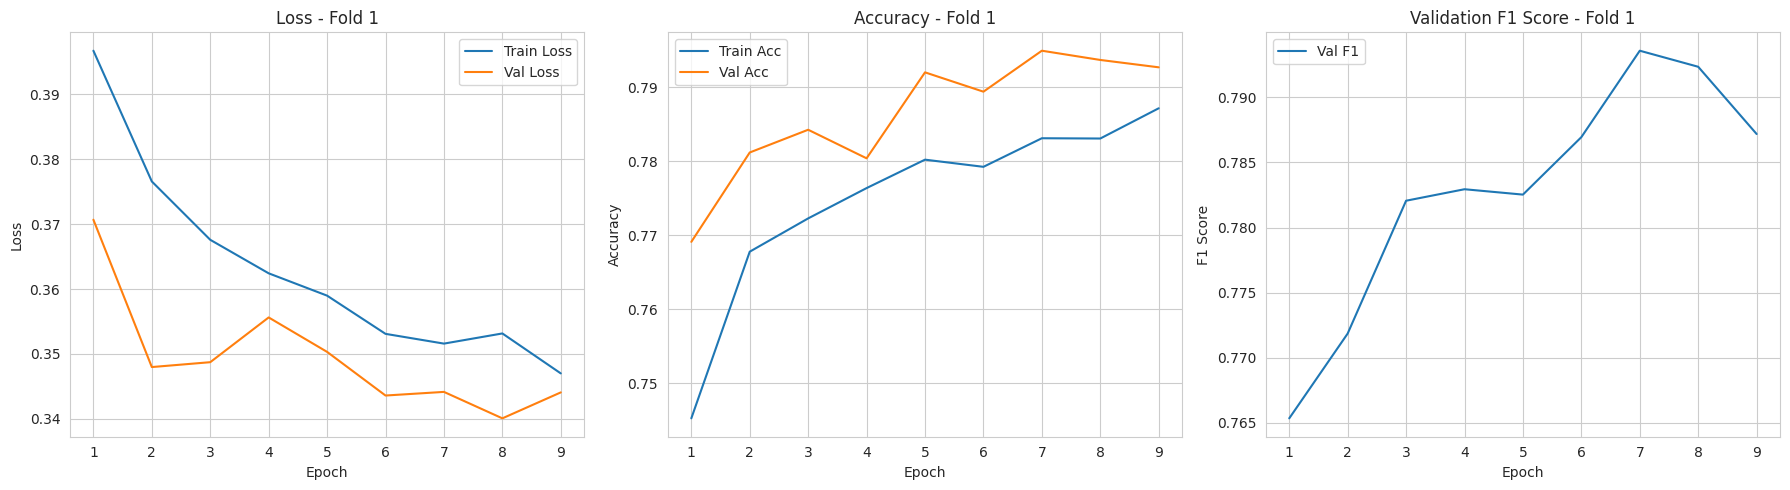

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 141.11it/s]


Fold 2, Epoch 0, Val F1 = 0.7586
Epoch [1/10] Train Loss: 0.4058 | Train Acc: 0.7421 | Val Loss: 0.3616 | Val Acc: 0.7716 | Val F1: 0.7586
Model saved with best F1: 0.7586


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 140.48it/s]


Fold 2, Epoch 1, Val F1 = 0.7787
Epoch [2/10] Train Loss: 0.3701 | Train Acc: 0.7671 | Val Loss: 0.3610 | Val Acc: 0.7827 | Val F1: 0.7787
Model saved with best F1: 0.7787


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 141.76it/s]


Fold 2, Epoch 2, Val F1 = 0.7672
Epoch [3/10] Train Loss: 0.3631 | Train Acc: 0.7701 | Val Loss: 0.3506 | Val Acc: 0.7754 | Val F1: 0.7672
No improvement at epoch 3


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 139.39it/s]


Fold 2, Epoch 3, Val F1 = 0.7810
Epoch [4/10] Train Loss: 0.3628 | Train Acc: 0.7757 | Val Loss: 0.3436 | Val Acc: 0.7837 | Val F1: 0.7810
Model saved with best F1: 0.7810


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 138.88it/s]


Fold 2, Epoch 4, Val F1 = 0.7799
Epoch [5/10] Train Loss: 0.3571 | Train Acc: 0.7832 | Val Loss: 0.3419 | Val Acc: 0.7853 | Val F1: 0.7799
No improvement at epoch 5


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 141.13it/s]


Fold 2, Epoch 5, Val F1 = 0.7829
Epoch [6/10] Train Loss: 0.3568 | Train Acc: 0.7808 | Val Loss: 0.3500 | Val Acc: 0.7874 | Val F1: 0.7829
Model saved with best F1: 0.7829


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 142.50it/s]


Fold 2, Epoch 6, Val F1 = 0.7754
Epoch [7/10] Train Loss: 0.3552 | Train Acc: 0.7849 | Val Loss: 0.3451 | Val Acc: 0.7829 | Val F1: 0.7754
No improvement at epoch 7


Validation Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 140.12it/s]


Fold 2, Epoch 7, Val F1 = 0.7781
Epoch [8/10] Train Loss: 0.3520 | Train Acc: 0.7845 | Val Loss: 0.3467 | Val Acc: 0.7878 | Val F1: 0.7781
No improvement at epoch 8
Stopped early at epoch 8

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


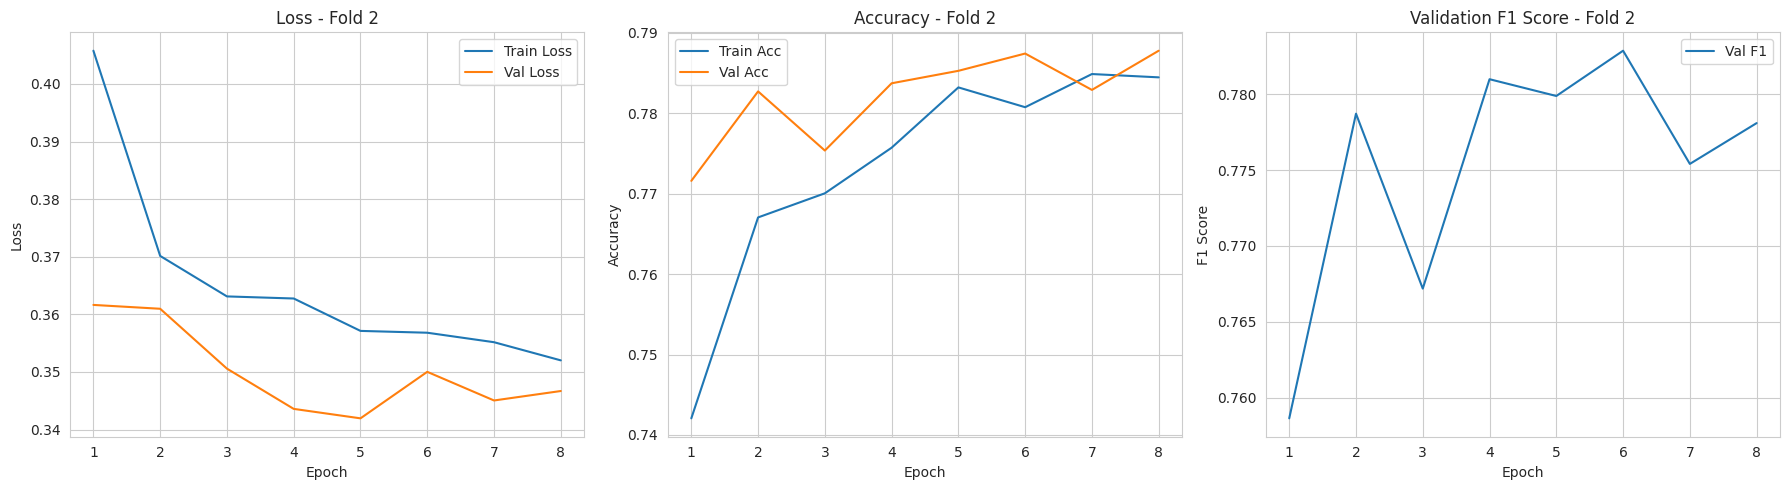

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 142.88it/s]


Fold 3, Epoch 0, Val F1 = 0.7522
Epoch [1/10] Train Loss: 0.4066 | Train Acc: 0.7435 | Val Loss: 0.3593 | Val Acc: 0.7731 | Val F1: 0.7522
Model saved with best F1: 0.7522


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 140.22it/s]


Fold 3, Epoch 1, Val F1 = 0.7712
Epoch [2/10] Train Loss: 0.3794 | Train Acc: 0.7646 | Val Loss: 0.3483 | Val Acc: 0.7797 | Val F1: 0.7712
Model saved with best F1: 0.7712


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 142.69it/s]


Fold 3, Epoch 2, Val F1 = 0.7729
Epoch [3/10] Train Loss: 0.3678 | Train Acc: 0.7729 | Val Loss: 0.3383 | Val Acc: 0.7814 | Val F1: 0.7729
Model saved with best F1: 0.7729


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 141.46it/s]


Fold 3, Epoch 3, Val F1 = 0.7820
Epoch [4/10] Train Loss: 0.3626 | Train Acc: 0.7754 | Val Loss: 0.3411 | Val Acc: 0.7880 | Val F1: 0.7820
Model saved with best F1: 0.7820


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 139.06it/s]


Fold 3, Epoch 4, Val F1 = 0.7814
Epoch [5/10] Train Loss: 0.3568 | Train Acc: 0.7770 | Val Loss: 0.3344 | Val Acc: 0.7877 | Val F1: 0.7814
No improvement at epoch 5


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 142.58it/s]


Fold 3, Epoch 5, Val F1 = 0.7812
Epoch [6/10] Train Loss: 0.3562 | Train Acc: 0.7838 | Val Loss: 0.3374 | Val Acc: 0.7879 | Val F1: 0.7812
No improvement at epoch 6
Stopped early at epoch 6

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


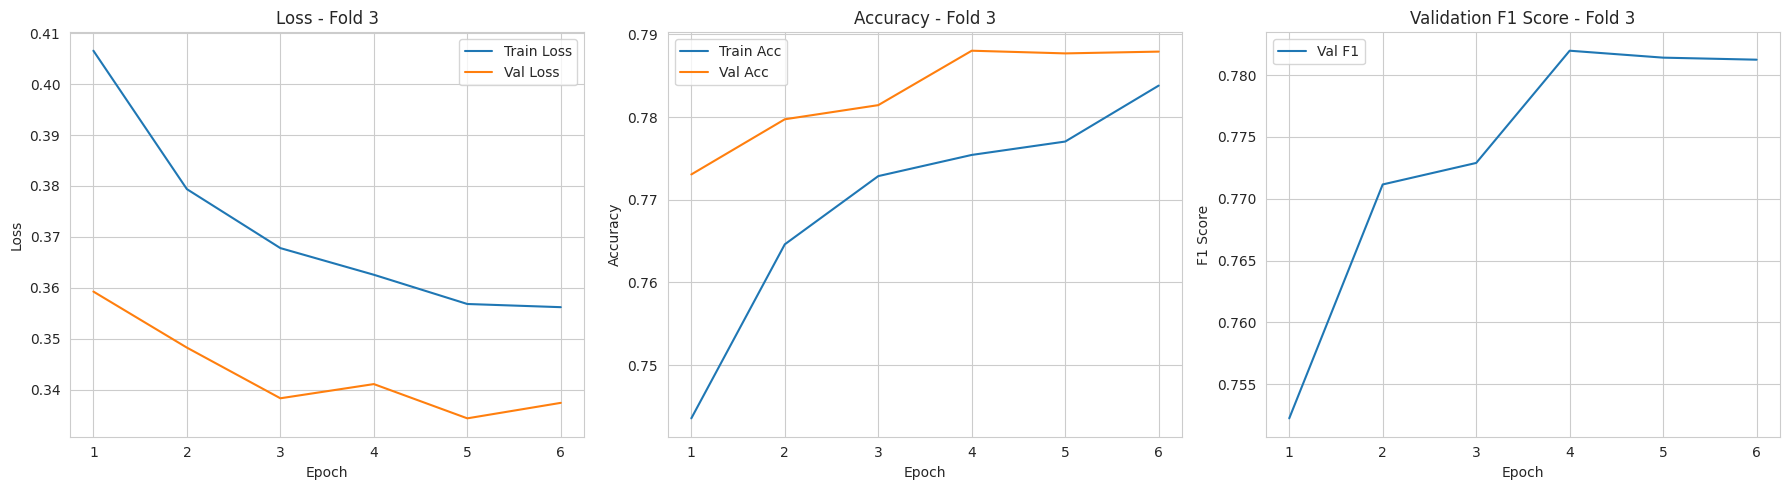

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 144.29it/s]


Fold 4, Epoch 0, Val F1 = 0.7692
Epoch [1/10] Train Loss: 0.4035 | Train Acc: 0.7421 | Val Loss: 0.3669 | Val Acc: 0.7789 | Val F1: 0.7692
Model saved with best F1: 0.7692


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 142.67it/s]


Fold 4, Epoch 1, Val F1 = 0.7765
Epoch [2/10] Train Loss: 0.3755 | Train Acc: 0.7683 | Val Loss: 0.3538 | Val Acc: 0.7834 | Val F1: 0.7765
Model saved with best F1: 0.7765


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 139.58it/s]


Fold 4, Epoch 2, Val F1 = 0.7816
Epoch [3/10] Train Loss: 0.3651 | Train Acc: 0.7718 | Val Loss: 0.3469 | Val Acc: 0.7878 | Val F1: 0.7816
Model saved with best F1: 0.7816


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 140.49it/s]


Fold 4, Epoch 3, Val F1 = 0.7560
Epoch [4/10] Train Loss: 0.3637 | Train Acc: 0.7752 | Val Loss: 0.3639 | Val Acc: 0.7733 | Val F1: 0.7560
No improvement at epoch 4


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 143.13it/s]


Fold 4, Epoch 4, Val F1 = 0.7830
Epoch [5/10] Train Loss: 0.3584 | Train Acc: 0.7767 | Val Loss: 0.3471 | Val Acc: 0.7895 | Val F1: 0.7830
Model saved with best F1: 0.7830


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 143.04it/s]


Fold 4, Epoch 5, Val F1 = 0.7863
Epoch [6/10] Train Loss: 0.3579 | Train Acc: 0.7817 | Val Loss: 0.3366 | Val Acc: 0.7898 | Val F1: 0.7863
Model saved with best F1: 0.7863


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 142.90it/s]


Fold 4, Epoch 6, Val F1 = 0.7854
Epoch [7/10] Train Loss: 0.3583 | Train Acc: 0.7826 | Val Loss: 0.3360 | Val Acc: 0.7908 | Val F1: 0.7854
No improvement at epoch 7


Validation Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 135.54it/s]


Fold 4, Epoch 7, Val F1 = 0.7927
Epoch [8/10] Train Loss: 0.3539 | Train Acc: 0.7829 | Val Loss: 0.3329 | Val Acc: 0.7958 | Val F1: 0.7927
Model saved with best F1: 0.7927


Validation Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 133.64it/s]


Fold 4, Epoch 8, Val F1 = 0.7811
Epoch [9/10] Train Loss: 0.3481 | Train Acc: 0.7848 | Val Loss: 0.3339 | Val Acc: 0.7892 | Val F1: 0.7811
No improvement at epoch 9


Validation Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 131.42it/s]


Fold 4, Epoch 9, Val F1 = 0.7925
Epoch [10/10] Train Loss: 0.3487 | Train Acc: 0.7859 | Val Loss: 0.3320 | Val Acc: 0.7982 | Val F1: 0.7925
No improvement at epoch 10
Stopped early at epoch 10

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


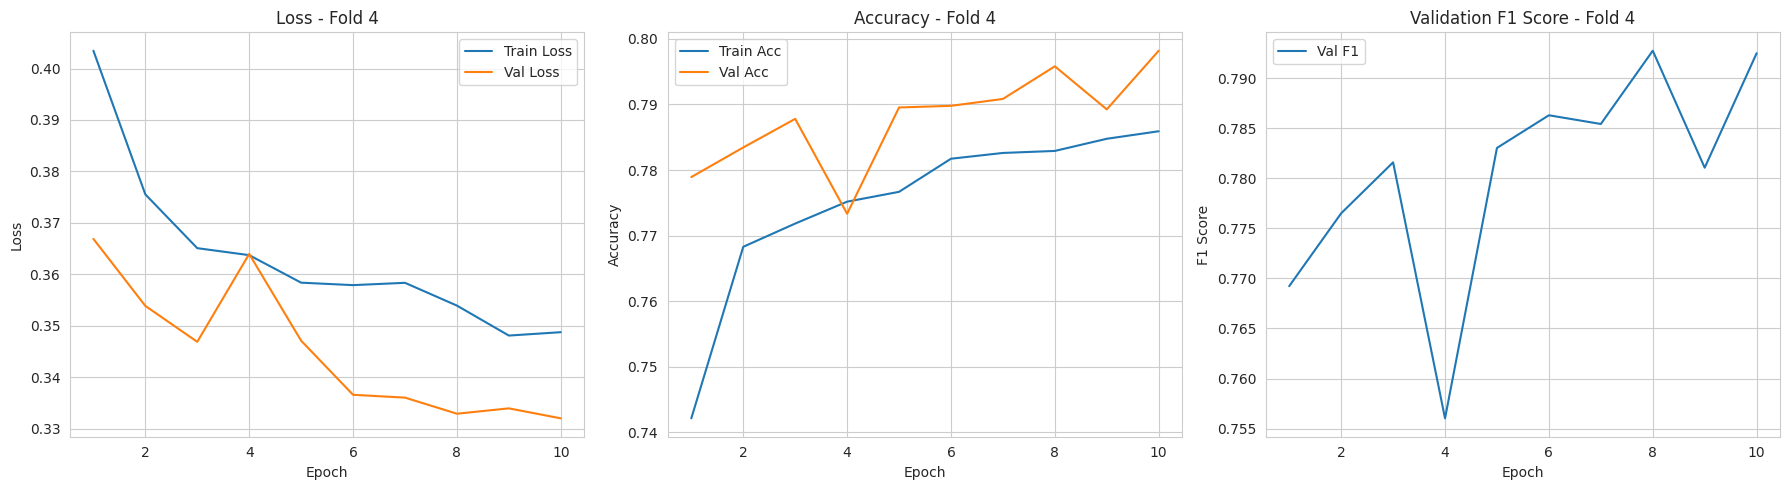

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 130.66it/s]


Fold 5, Epoch 0, Val F1 = 0.7652
Epoch [1/10] Train Loss: 0.3996 | Train Acc: 0.7451 | Val Loss: 0.3729 | Val Acc: 0.7662 | Val F1: 0.7652
Model saved with best F1: 0.7652


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 144.80it/s]


Fold 5, Epoch 1, Val F1 = 0.7874
Epoch [2/10] Train Loss: 0.3727 | Train Acc: 0.7681 | Val Loss: 0.3437 | Val Acc: 0.7905 | Val F1: 0.7874
Model saved with best F1: 0.7874


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 142.49it/s]


Fold 5, Epoch 2, Val F1 = 0.7710
Epoch [3/10] Train Loss: 0.3673 | Train Acc: 0.7717 | Val Loss: 0.3422 | Val Acc: 0.7846 | Val F1: 0.7710
No improvement at epoch 3


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 142.66it/s]


Fold 5, Epoch 3, Val F1 = 0.7816
Epoch [4/10] Train Loss: 0.3635 | Train Acc: 0.7757 | Val Loss: 0.3426 | Val Acc: 0.7913 | Val F1: 0.7816
No improvement at epoch 4
Stopped early at epoch 4

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


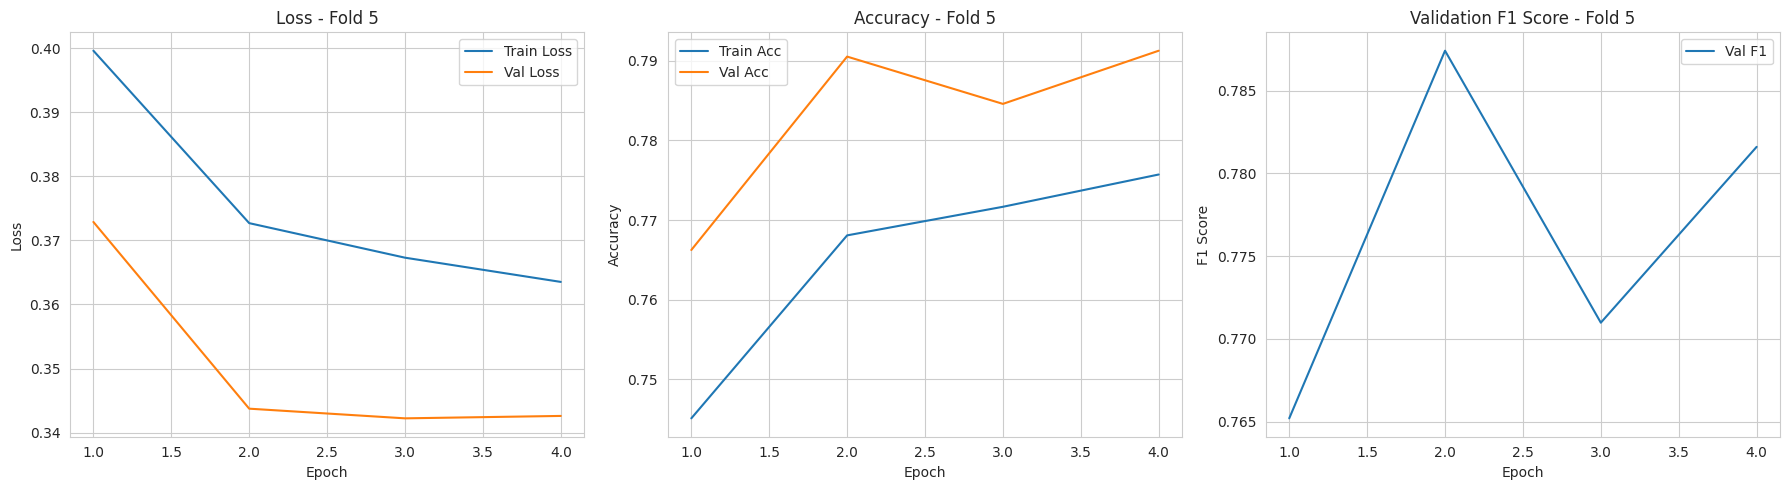

Config 2 mean F1 = 0.7877

=== Running config 3/6: {'lr': 0.0003, 'hidden_dims': (128, 64), 'scheduler': 'cosine', 'dropout': 0.5, 'input_dim': 118, 'epochs': 10}


Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 138.41it/s]


Fold 1, Epoch 0, Val F1 = 0.7509
Epoch [1/10] Train Loss: 0.4438 | Train Acc: 0.7113 | Val Loss: 0.3764 | Val Acc: 0.7693 | Val F1: 0.7509
Model saved with best F1: 0.7509


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 142.80it/s]


Fold 1, Epoch 1, Val F1 = 0.7399
Epoch [2/10] Train Loss: 0.3931 | Train Acc: 0.7535 | Val Loss: 0.3678 | Val Acc: 0.7612 | Val F1: 0.7399
No improvement at epoch 2


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 139.06it/s]


Fold 1, Epoch 2, Val F1 = 0.7788
Epoch [3/10] Train Loss: 0.3853 | Train Acc: 0.7612 | Val Loss: 0.3528 | Val Acc: 0.7858 | Val F1: 0.7788
Model saved with best F1: 0.7788


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 141.88it/s]


Fold 1, Epoch 3, Val F1 = 0.7777
Epoch [4/10] Train Loss: 0.3773 | Train Acc: 0.7688 | Val Loss: 0.3557 | Val Acc: 0.7873 | Val F1: 0.7777
No improvement at epoch 4


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 140.21it/s]


Fold 1, Epoch 4, Val F1 = 0.7624
Epoch [5/10] Train Loss: 0.3784 | Train Acc: 0.7686 | Val Loss: 0.3555 | Val Acc: 0.7816 | Val F1: 0.7624
No improvement at epoch 5
Stopped early at epoch 5

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


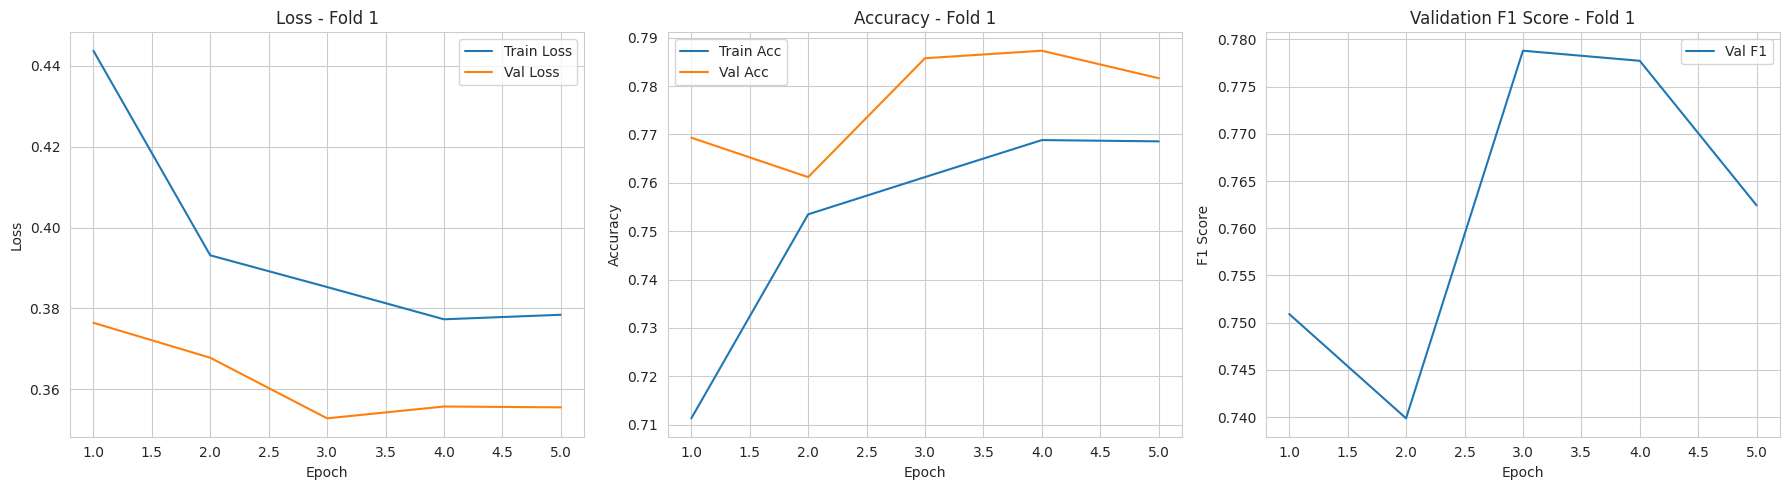

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 144.23it/s]


Fold 2, Epoch 0, Val F1 = 0.7485
Epoch [1/10] Train Loss: 0.4379 | Train Acc: 0.7122 | Val Loss: 0.3799 | Val Acc: 0.7672 | Val F1: 0.7485
Model saved with best F1: 0.7485


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 137.63it/s]


Fold 2, Epoch 1, Val F1 = 0.7482
Epoch [2/10] Train Loss: 0.3963 | Train Acc: 0.7532 | Val Loss: 0.3692 | Val Acc: 0.7680 | Val F1: 0.7482
No improvement at epoch 2


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 141.19it/s]


Fold 2, Epoch 2, Val F1 = 0.7634
Epoch [3/10] Train Loss: 0.3800 | Train Acc: 0.7607 | Val Loss: 0.3527 | Val Acc: 0.7741 | Val F1: 0.7634
Model saved with best F1: 0.7634


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 141.12it/s]


Fold 2, Epoch 3, Val F1 = 0.7663
Epoch [4/10] Train Loss: 0.3797 | Train Acc: 0.7657 | Val Loss: 0.3525 | Val Acc: 0.7792 | Val F1: 0.7663
Model saved with best F1: 0.7663


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 138.93it/s]


Fold 2, Epoch 4, Val F1 = 0.7704
Epoch [5/10] Train Loss: 0.3763 | Train Acc: 0.7706 | Val Loss: 0.3604 | Val Acc: 0.7834 | Val F1: 0.7704
Model saved with best F1: 0.7704


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 137.18it/s]


Fold 2, Epoch 5, Val F1 = 0.7704
Epoch [6/10] Train Loss: 0.3716 | Train Acc: 0.7711 | Val Loss: 0.3614 | Val Acc: 0.7807 | Val F1: 0.7704
Model saved with best F1: 0.7704


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 141.69it/s]


Fold 2, Epoch 6, Val F1 = 0.7731
Epoch [7/10] Train Loss: 0.3680 | Train Acc: 0.7751 | Val Loss: 0.3485 | Val Acc: 0.7831 | Val F1: 0.7731
Model saved with best F1: 0.7731


Validation Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 140.67it/s]


Fold 2, Epoch 7, Val F1 = 0.7759
Epoch [8/10] Train Loss: 0.3630 | Train Acc: 0.7769 | Val Loss: 0.3433 | Val Acc: 0.7806 | Val F1: 0.7759
Model saved with best F1: 0.7759


Validation Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 144.22it/s]


Fold 2, Epoch 8, Val F1 = 0.7766
Epoch [9/10] Train Loss: 0.3669 | Train Acc: 0.7764 | Val Loss: 0.3521 | Val Acc: 0.7869 | Val F1: 0.7766
Model saved with best F1: 0.7766


Validation Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 138.83it/s]


Fold 2, Epoch 9, Val F1 = 0.7786
Epoch [10/10] Train Loss: 0.3646 | Train Acc: 0.7794 | Val Loss: 0.3542 | Val Acc: 0.7842 | Val F1: 0.7786
Model saved with best F1: 0.7786

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


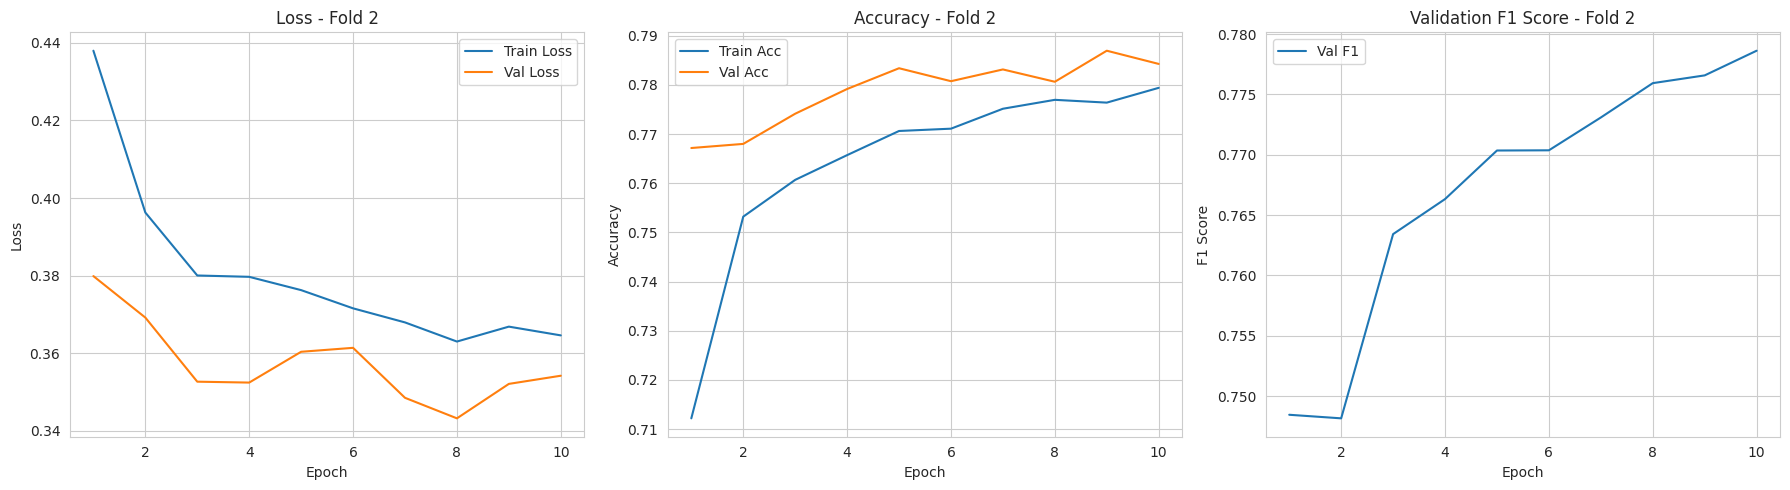

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 142.44it/s]


Fold 3, Epoch 0, Val F1 = 0.7509
Epoch [1/10] Train Loss: 0.4401 | Train Acc: 0.7124 | Val Loss: 0.3775 | Val Acc: 0.7607 | Val F1: 0.7509
Model saved with best F1: 0.7509


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 142.19it/s]


Fold 3, Epoch 1, Val F1 = 0.7677
Epoch [2/10] Train Loss: 0.3951 | Train Acc: 0.7531 | Val Loss: 0.3652 | Val Acc: 0.7779 | Val F1: 0.7677
Model saved with best F1: 0.7677


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 144.55it/s]


Fold 3, Epoch 2, Val F1 = 0.7754
Epoch [3/10] Train Loss: 0.3884 | Train Acc: 0.7632 | Val Loss: 0.3518 | Val Acc: 0.7777 | Val F1: 0.7754
Model saved with best F1: 0.7754


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 141.32it/s]


Fold 3, Epoch 3, Val F1 = 0.7744
Epoch [4/10] Train Loss: 0.3839 | Train Acc: 0.7658 | Val Loss: 0.3571 | Val Acc: 0.7844 | Val F1: 0.7744
No improvement at epoch 4


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 143.26it/s]


Fold 3, Epoch 4, Val F1 = 0.7783
Epoch [5/10] Train Loss: 0.3797 | Train Acc: 0.7709 | Val Loss: 0.3410 | Val Acc: 0.7852 | Val F1: 0.7783
Model saved with best F1: 0.7783


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 141.71it/s]


Fold 3, Epoch 5, Val F1 = 0.7746
Epoch [6/10] Train Loss: 0.3718 | Train Acc: 0.7715 | Val Loss: 0.3409 | Val Acc: 0.7778 | Val F1: 0.7746
No improvement at epoch 6


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 145.47it/s]


Fold 3, Epoch 6, Val F1 = 0.7757
Epoch [7/10] Train Loss: 0.3701 | Train Acc: 0.7715 | Val Loss: 0.3350 | Val Acc: 0.7845 | Val F1: 0.7757
No improvement at epoch 7
Stopped early at epoch 7

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


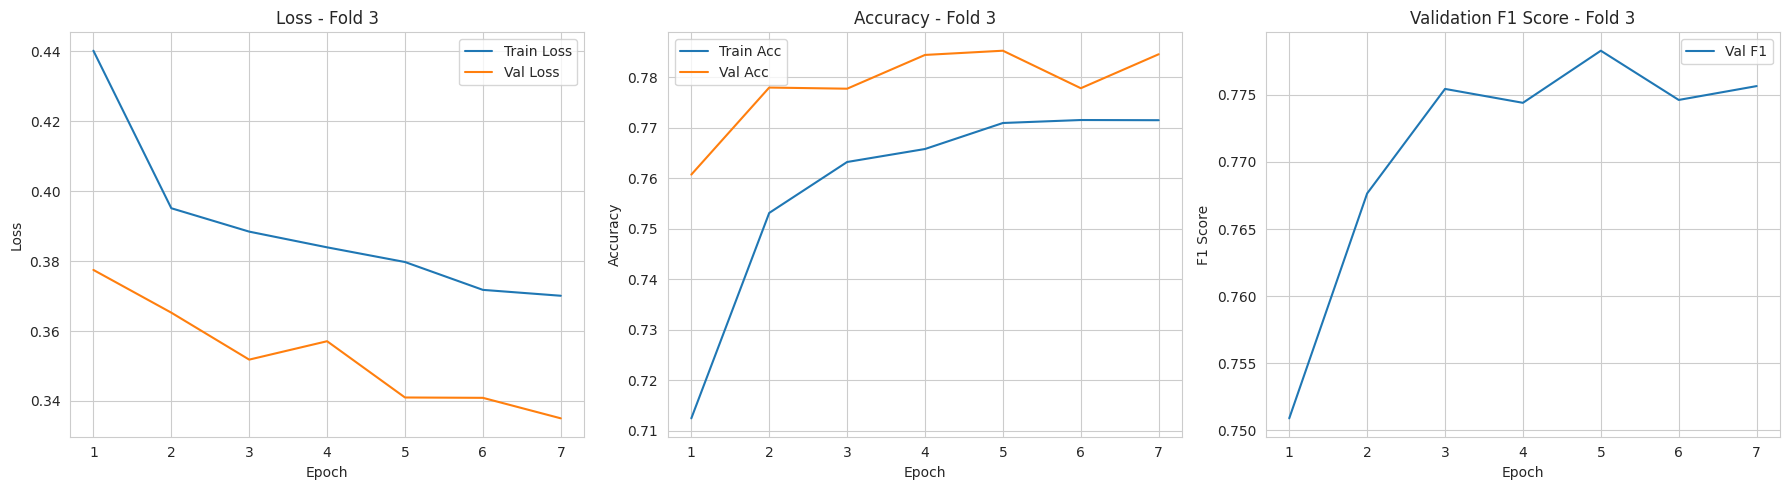

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 137.76it/s]


Fold 4, Epoch 0, Val F1 = 0.7566
Epoch [1/10] Train Loss: 0.4365 | Train Acc: 0.7104 | Val Loss: 0.3810 | Val Acc: 0.7703 | Val F1: 0.7566
Model saved with best F1: 0.7566


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 144.48it/s]


Fold 4, Epoch 1, Val F1 = 0.7587
Epoch [2/10] Train Loss: 0.3942 | Train Acc: 0.7509 | Val Loss: 0.3651 | Val Acc: 0.7728 | Val F1: 0.7587
Model saved with best F1: 0.7587


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 135.85it/s]


Fold 4, Epoch 2, Val F1 = 0.7536
Epoch [3/10] Train Loss: 0.3856 | Train Acc: 0.7633 | Val Loss: 0.3607 | Val Acc: 0.7747 | Val F1: 0.7536
No improvement at epoch 3


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 144.27it/s]


Fold 4, Epoch 3, Val F1 = 0.7718
Epoch [4/10] Train Loss: 0.3818 | Train Acc: 0.7661 | Val Loss: 0.3528 | Val Acc: 0.7817 | Val F1: 0.7718
Model saved with best F1: 0.7718


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 139.90it/s]


Fold 4, Epoch 4, Val F1 = 0.7818
Epoch [5/10] Train Loss: 0.3757 | Train Acc: 0.7678 | Val Loss: 0.3461 | Val Acc: 0.7854 | Val F1: 0.7818
Model saved with best F1: 0.7818


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 142.45it/s]


Fold 4, Epoch 5, Val F1 = 0.7856
Epoch [6/10] Train Loss: 0.3722 | Train Acc: 0.7696 | Val Loss: 0.3505 | Val Acc: 0.7890 | Val F1: 0.7856
Model saved with best F1: 0.7856


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 140.89it/s]


Fold 4, Epoch 6, Val F1 = 0.7751
Epoch [7/10] Train Loss: 0.3685 | Train Acc: 0.7717 | Val Loss: 0.3451 | Val Acc: 0.7823 | Val F1: 0.7751
No improvement at epoch 7


Validation Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 143.55it/s]


Fold 4, Epoch 7, Val F1 = 0.7763
Epoch [8/10] Train Loss: 0.3668 | Train Acc: 0.7753 | Val Loss: 0.3396 | Val Acc: 0.7810 | Val F1: 0.7763
No improvement at epoch 8
Stopped early at epoch 8

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


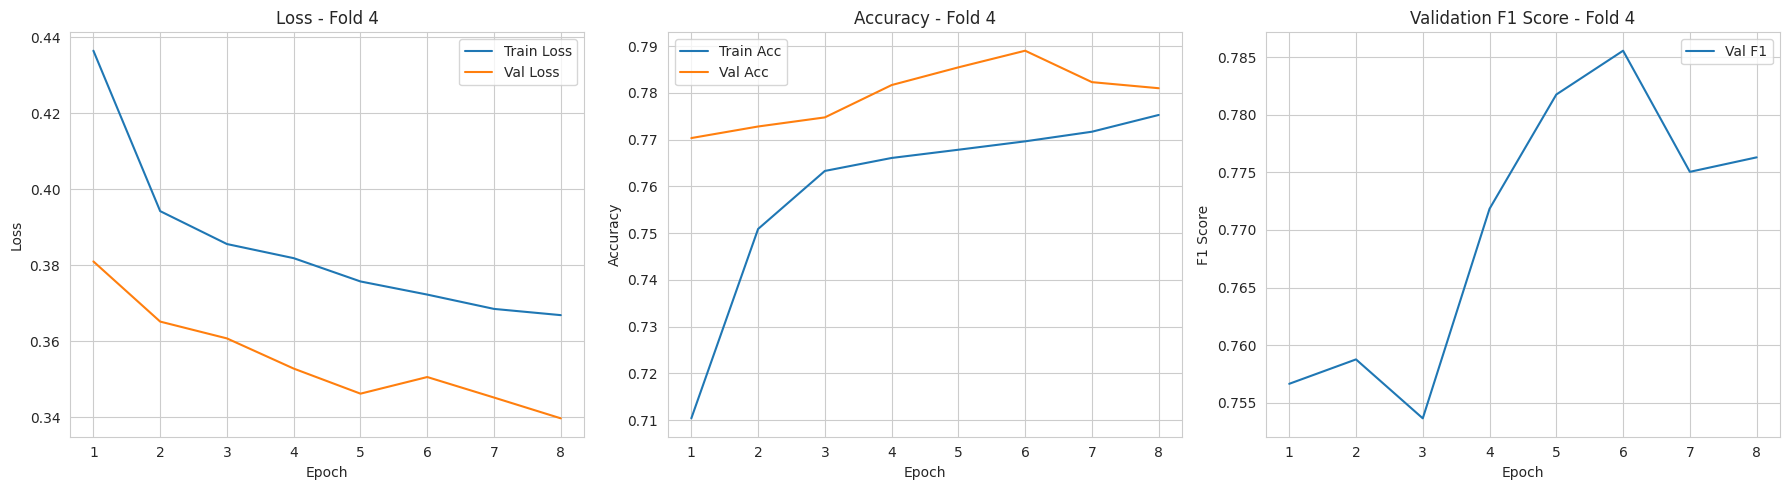

Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 138.63it/s]


Fold 5, Epoch 0, Val F1 = 0.7483
Epoch [1/10] Train Loss: 0.4342 | Train Acc: 0.7105 | Val Loss: 0.3707 | Val Acc: 0.7667 | Val F1: 0.7483
Model saved with best F1: 0.7483


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 143.29it/s]


Fold 5, Epoch 1, Val F1 = 0.7725
Epoch [2/10] Train Loss: 0.4011 | Train Acc: 0.7515 | Val Loss: 0.3672 | Val Acc: 0.7839 | Val F1: 0.7725
Model saved with best F1: 0.7725


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 139.51it/s]


Fold 5, Epoch 2, Val F1 = 0.7664
Epoch [3/10] Train Loss: 0.3909 | Train Acc: 0.7590 | Val Loss: 0.3598 | Val Acc: 0.7810 | Val F1: 0.7664
No improvement at epoch 3


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 139.85it/s]


Fold 5, Epoch 3, Val F1 = 0.7765
Epoch [4/10] Train Loss: 0.3799 | Train Acc: 0.7654 | Val Loss: 0.3385 | Val Acc: 0.7851 | Val F1: 0.7765
Model saved with best F1: 0.7765


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 137.18it/s]


Fold 5, Epoch 4, Val F1 = 0.7865
Epoch [5/10] Train Loss: 0.3757 | Train Acc: 0.7670 | Val Loss: 0.3504 | Val Acc: 0.7925 | Val F1: 0.7865
Model saved with best F1: 0.7865


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 136.36it/s]


Fold 5, Epoch 5, Val F1 = 0.7802
Epoch [6/10] Train Loss: 0.3721 | Train Acc: 0.7691 | Val Loss: 0.3435 | Val Acc: 0.7873 | Val F1: 0.7802
No improvement at epoch 6


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 141.12it/s]


Fold 5, Epoch 6, Val F1 = 0.7846
Epoch [7/10] Train Loss: 0.3665 | Train Acc: 0.7737 | Val Loss: 0.3509 | Val Acc: 0.7934 | Val F1: 0.7846
No improvement at epoch 7
Stopped early at epoch 7

 Best config so far: spect_mlp_fold3_lr0.0003_dim(128, 64) with F1 = 0.7973


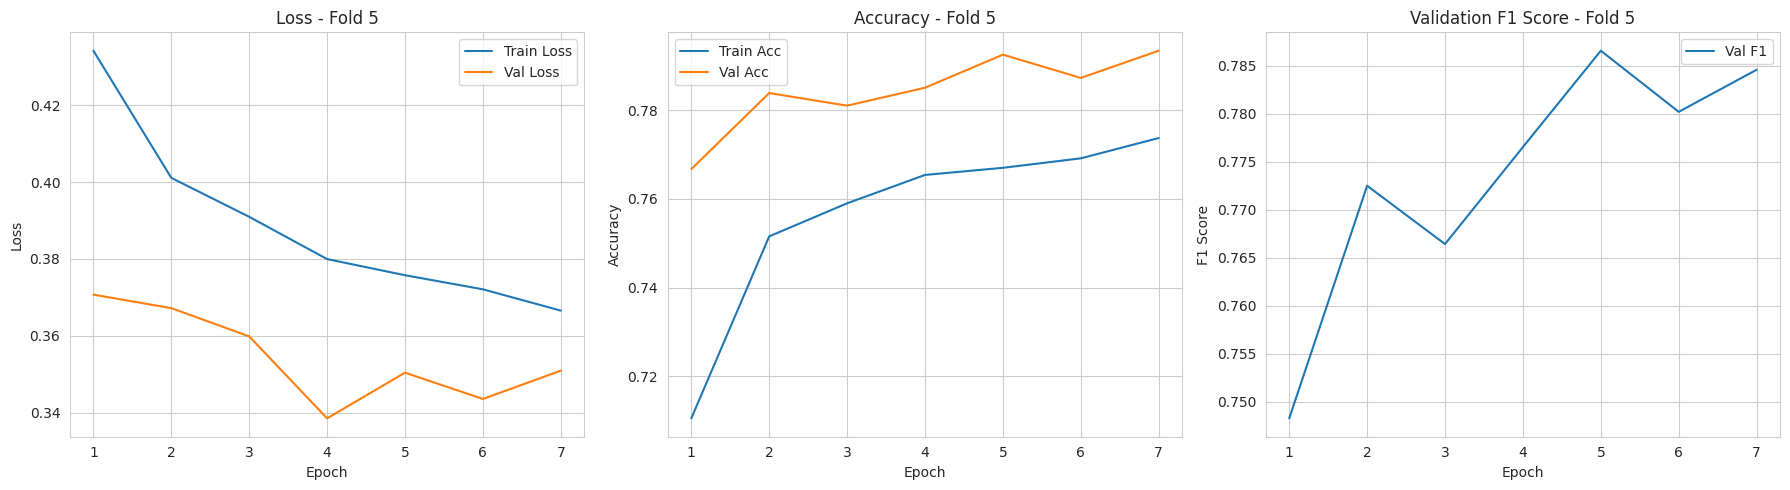

Config 3 mean F1 = 0.7816

=== Running config 4/6: {'lr': 0.0003, 'hidden_dims': (512, 256, 128), 'scheduler': 'cosine', 'dropout': 0.1, 'input_dim': 118, 'epochs': 10}


Validation Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 139.23it/s]


Fold 1, Epoch 0, Val F1 = 0.7772
Epoch [1/10] Train Loss: 0.3821 | Train Acc: 0.7596 | Val Loss: 0.3510 | Val Acc: 0.7782 | Val F1: 0.7772
Model saved with best F1: 0.7772


Validation Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 138.20it/s]


Fold 1, Epoch 1, Val F1 = 0.7770
Epoch [2/10] Train Loss: 0.3645 | Train Acc: 0.7749 | Val Loss: 0.3498 | Val Acc: 0.7813 | Val F1: 0.7770
No improvement at epoch 2


Validation Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 137.92it/s]


Fold 1, Epoch 2, Val F1 = 0.7834
Epoch [3/10] Train Loss: 0.3599 | Train Acc: 0.7804 | Val Loss: 0.3473 | Val Acc: 0.7840 | Val F1: 0.7834
Model saved with best F1: 0.7834


Validation Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 140.04it/s]


Fold 1, Epoch 3, Val F1 = 0.7841
Epoch [4/10] Train Loss: 0.3513 | Train Acc: 0.7835 | Val Loss: 0.3410 | Val Acc: 0.7924 | Val F1: 0.7841
Model saved with best F1: 0.7841


Validation Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 139.38it/s]


Fold 1, Epoch 4, Val F1 = 0.7928
Epoch [5/10] Train Loss: 0.3461 | Train Acc: 0.7838 | Val Loss: 0.3373 | Val Acc: 0.7924 | Val F1: 0.7928
Model saved with best F1: 0.7928


Validation Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 139.55it/s]


Fold 1, Epoch 5, Val F1 = 0.7887
Epoch [6/10] Train Loss: 0.3415 | Train Acc: 0.7885 | Val Loss: 0.3492 | Val Acc: 0.7938 | Val F1: 0.7887
No improvement at epoch 6


Validation Epoch 7: 100%|██████████| 250/250 [00:01<00:00, 139.33it/s]


Fold 1, Epoch 6, Val F1 = 0.7933
Epoch [7/10] Train Loss: 0.3410 | Train Acc: 0.7873 | Val Loss: 0.3334 | Val Acc: 0.7959 | Val F1: 0.7933
Model saved with best F1: 0.7933


Validation Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 140.94it/s]


Fold 1, Epoch 7, Val F1 = 0.7970
Epoch [8/10] Train Loss: 0.3393 | Train Acc: 0.7926 | Val Loss: 0.3335 | Val Acc: 0.7987 | Val F1: 0.7970
Model saved with best F1: 0.7970


Validation Epoch 9: 100%|██████████| 250/250 [00:01<00:00, 134.89it/s]


Fold 1, Epoch 8, Val F1 = 0.7987
Epoch [9/10] Train Loss: 0.3386 | Train Acc: 0.7941 | Val Loss: 0.3303 | Val Acc: 0.7963 | Val F1: 0.7987
Model saved with best F1: 0.7987


Validation Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 138.70it/s]


Fold 1, Epoch 9, Val F1 = 0.7972
Epoch [10/10] Train Loss: 0.3367 | Train Acc: 0.7937 | Val Loss: 0.3265 | Val Acc: 0.8005 | Val F1: 0.7972
No improvement at epoch 10

 Best config so far: spect_mlp_fold1_lr0.0003_dim(512, 256, 128) with F1 = 0.7987


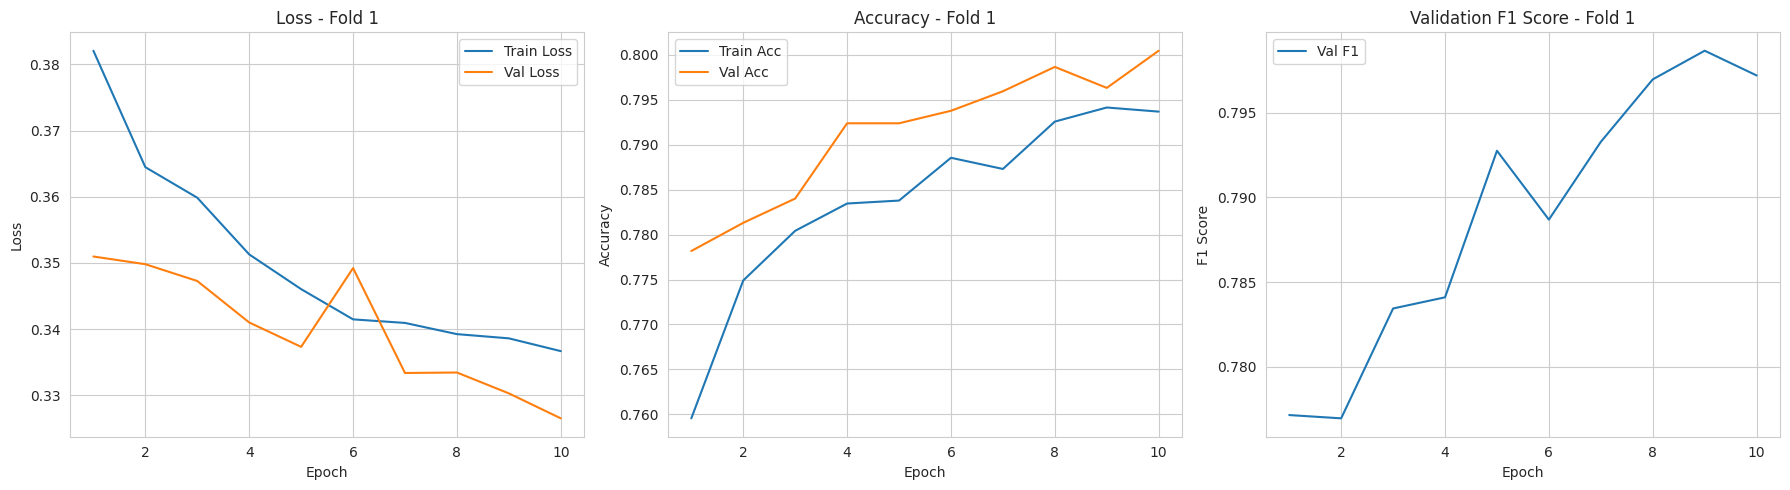

Validation Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
# Try the MLP on the radial profiles + other spectral stats

from sklearn.model_selection import StratifiedKFold
from itertools import product
from sklearn.metrics import f1_score
from tqdm import tqdm

train_X, train_y = train_df['file_name'], train_df['label']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_grid = {
    # 'lr':           [1e-4, 3e-4, 1e-3],
    'lr':           [3e-4],
    # 'weight_decay': [1e-5],
    'hidden_dims':  [(128,64), (512,256,128)],
    # 'hidden_dims':  [(256,128,64)],
    'scheduler': ['cosine'],
    'dropout':      [0.1, 0.2, 0.5],
    # 'batch_size':   [32, 64],
    # 'use_batchnorm':[True, False],
    # 'patience':     [2, 4]
}

best_overall = {'f1':0.0, 'config':None}

all_configs = []
keys = list(param_grid.keys())
for vals in product(*param_grid.values()):
    cfg = dict(zip(keys, vals))
    cfg['input_dim'] = X_np.shape[1]
    cfg['epochs']    = epochs
    all_configs.append(cfg)

for i, cfg in enumerate(all_configs):
    print(f"\n=== Running config {i+1}/{len(all_configs)}: {cfg}")
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_f1s = []
    X = torch.from_numpy(X_np).float()
    y = torch.from_numpy(train_y.values).long()
    for fold, (tr, va) in enumerate(kf.split(X, y), 1):
        f1 = train_fold(tr, va, fold, cfg)
        fold_f1s.append(f1)
    mean_f1 = np.mean(fold_f1s)
    print(f"Config {i+1} mean F1 = {mean_f1:.4f}")
    if mean_f1 > best_overall['f1']:
        best_overall = {'f1':mean_f1, 'config':cfg}

print("!!! Best config:", best_overall)

In [ ]:
torch.cuda.empty_cache()

In [2]:
# Now load the best models and test them on the test set
WEIGHTS_PATH = "/content/best_weights_spect_mlp_fold3_lr0.0003_dim(128, 64).pth"

def load_test_data(model):
    global test_loader
    config = resolve_data_config({}, model=model, use_test_size=True)
    image_size = config['input_size'][-1]  # Usually (3, H, W), we take H/W
    transform = create_transform(**config)

    print("Expected input size:", config['input_size'])  # Add debug line

    # Override transform to be explicit and safe
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB')),
        transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config['mean'],
            std=config['std']
        )
    ])
    test_dataset = TensorDataset(spect_test_features)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load
# model = timm.create_model('efficientnetv2_rw_s.ra2_in1k', pretrained=False, num_classes=1)
model = SpecMLP(
    input_dim   = X_np.shape[1],
    hidden_dims = (128,64)
)
model = model.to(device)
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

scaler = StandardScaler()
X_np_test = scaler.fit_transform(X_np_test)
X_test = torch.from_numpy(X_np_test).float()
y_test = torch.zeros(len(X_np_test))
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# List to store predictions
test_predictions = []

# Disable gradient computation (as we are not training)
with torch.no_grad():
    # Wrap the test_loader with tqdm to display a progress bar
    for data, _ in tqdm(test_loader, desc="Inference Progress", total=len(test_loader)):
        data = data.to(device)
        output = model(data)  # Get model output

        # Get predicted class labels (0 or 1)
        preds = output.argmax(dim=1)  # Get class with highest probability

        # Store predictions
        test_predictions.extend(preds.cpu().numpy())

test_predictions = np.array(test_predictions)

submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["label"] = test_predictions  # Assign 1D predictions

submission_df.to_csv("submission.csv", index=False)

NameError: name 'SpecMLP' is not defined

label
0    3737
1    1803
Name: count, dtype: int64


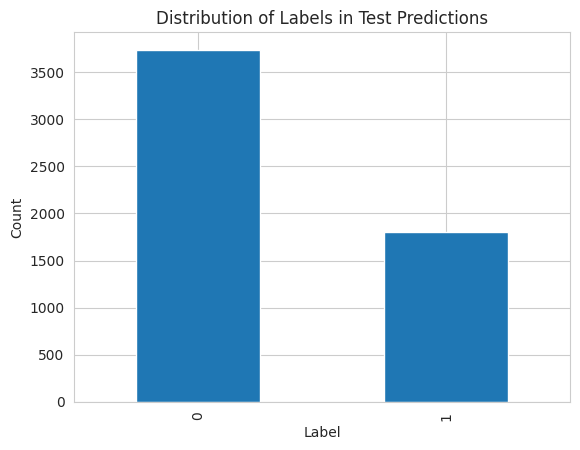

In [ ]:
def plot_submission(submission_df):
    # Analyze the distribution of the 'label' field in test_predictions
    print(submission_df['label'].value_counts())
    submission_df['label'].value_counts().plot(kind='bar')
    plt.title('Distribution of Labels in Test Predictions')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

plot_submission(submission_df)

In [ ]:
import json

# Now let's try the timm models again on the pre-computed spectra

epochs = 3
# epochs_without_improvement = 0
patience = 2
overall_best_f1 = 0.0
results = {}
overall_best_config = ""
pos_weight = 0.4
def train_fold_timm(train_loader, val_loader, fold, config):
    global overall_best_f1, overall_best_config  # Declare as global
    # config is a dict containing all hyperparams
    model = timm.create_model(
        config['model'],
        pretrained=True,
        in_chans=1,            # one‑channel spectrum inputs
        num_classes=2
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config['lr'],
        weight_decay=1e-2
    )
    scheduler = get_scheduler(optimizer, config['scheduler'])
    pw = torch.tensor([pos_weight]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
    patience = 2
    batch_size = 64

    # split tensors
    # X_train, y_train = X[train_idx], y[train_idx]
    # X_val,   y_val   = X[val_idx],   y[val_idx]

    # X_train = X_train.cpu().numpy()
    # X_val = X_val.cpu().numpy()

    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_val = scaler.transform(X_val)

    # # Convert back to PyTorch tensors after scaling
    # X_train = torch.from_numpy(X_train).float()
    # X_val = torch.from_numpy(X_val).float()
    # y_train = y_train
    # y_val = y_val


    # # dataloaders
    # train_ds = TensorDataset(X_train, y_train)
    # val_ds   = TensorDataset(X_val,   y_val)
    # train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    # val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

    # Initialize lists to store loss, accuracy, and F1 scores
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1s = []


    val_loss = 0.0
    val_acc = 0.0

    best_f1 = 0.0
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Train the model
    for epoch in range(epochs):

        epoch_loss = 0.0
        epoch_accuracy = 0.0
        epoch_f1 = 0.0

        # training
        model.train()
        for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            logits = model(data)
            label = label.unsqueeze(1).float()  # Add a dimension and convert to float

            loss = criterion(logits[:,1], label.squeeze(1))
            # loss = criterion(logits, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_accuracy += (logits.argmax(dim=1) == label).float().mean()

        epoch_loss /= len(train_loader)
        epoch_accuracy /= len(train_loader)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy.item())

        # validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                # data, label = data.to(device), label.to(device)
                data = data.to(device, non_blocking=True)
                label = label.to(device, non_blocking=True)
                logits = model(data)
                loss = criterion(logits[:,1], label.float())
                # loss = criterion(logits, label)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                val_acc += (preds == label).float().mean().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(label.cpu().numpy())


        f1 = f1_score(all_labels, all_preds)
        print(f"Fold {fold}, Epoch {epoch}, Val F1 = {f1:.4f}")


        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Calculate F1 Score
        val_f1 = f1_score(all_labels, all_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)


        # Print progress
        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
        )

        config_key = f"{config['model']}_fold{fold}_lr{config['lr']}_sched{config['scheduler']}"
        # Early Stopping Logic
        # Check improvement
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f"best_weights_{config_key}.pth")
            torch.save(model, f"best_model_{config_key}.pt")
            print(f"Model saved with best F1: {best_f1:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No improvement at epoch {epoch+1}")

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        if epochs_without_improvement >= patience:
            print(f"Stopped early at epoch {epoch+1}")
            break
        del model

    results[config_key] = {
        "best_f1": best_f1,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "val_f1s": val_f1s,
        "fold": fold,
        "model": config['model']
    }

    if best_f1 > overall_best_f1:
        overall_best_f1 = best_f1
        overall_best_config = config_key


    with open("timm_model_f1_results.json", "w") as f:
        json.dump(results, f, indent=4)




    if best_f1 > overall_best_f1:
        overall_best_f1 = best_f1
        overall_best_config = config_key

    print(f"\n Best config so far: {overall_best_config} with F1 = {overall_best_f1:.4f}")
    plot_metrics(train_losses, val_losses, [torch.tensor(acc) for acc in train_accuracies], val_accuracies, val_f1s, fold)
    return best_f1

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transforms = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import Dataset
import torch

class MemmapSpectra(Dataset):
    def __init__(self, specs_mm, labels_mm, mean, std):
        self.specs = specs_mm
        self.labels = labels_mm
        self.mean = mean
        self.std  = std

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # get a single [H,W] float16 slice and normalize
        spec = (self.specs[idx].astype(np.float32) - self.mean) / (self.std + 1e-6)
        # to torch, add channel dim
        return torch.from_numpy(spec).unsqueeze(0), int(self.labels[idx])


class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = pd.DataFrame(df)  # Ensure it's a DataFrame
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["file_name"]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.df.iloc[idx]["label"]
        return img, label

class CustomTestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = pd.DataFrame(df)  # Ensure it's a DataFrame
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["id"]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, 0

In [ ]:
X_train, X_val, y_train, y_val = None, None, None, None

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df['file_name'], train_df['label'], test_size=0.2, random_state=42)
X_train = pd.DataFrame({'file_name': X_train, 'label': y_train})
X_val = pd.DataFrame({'file_name': X_val, 'label': y_val})
train_ds = CustomDataset(X_train, transform=train_transforms)
val_ds = CustomDataset(X_val, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc

gc.collect()

NameError: name 'label' is not defined


=== Running config 1/2: {'model': 'efficientnetv2_rw_s.ra2_in1k', 'lr': 0.0001, 'scheduler': 'cosine'}


Validation Epoch 1: 100%|██████████| 250/250 [00:24<00:00, 10.11it/s]


Fold 1, Epoch 0, Val F1 = 0.5557
Epoch [1/1] Train Loss: 0.3031 | Train Acc: 0.5005 | Val Loss: 0.2405 | Val Acc: 0.6877 | Val F1: 0.5557
Model saved with best F1: 0.5557

 Best config so far: efficientnetv2_rw_s.ra2_in1k_fold1_lr0.0001_schedcosine with F1 = 0.5557


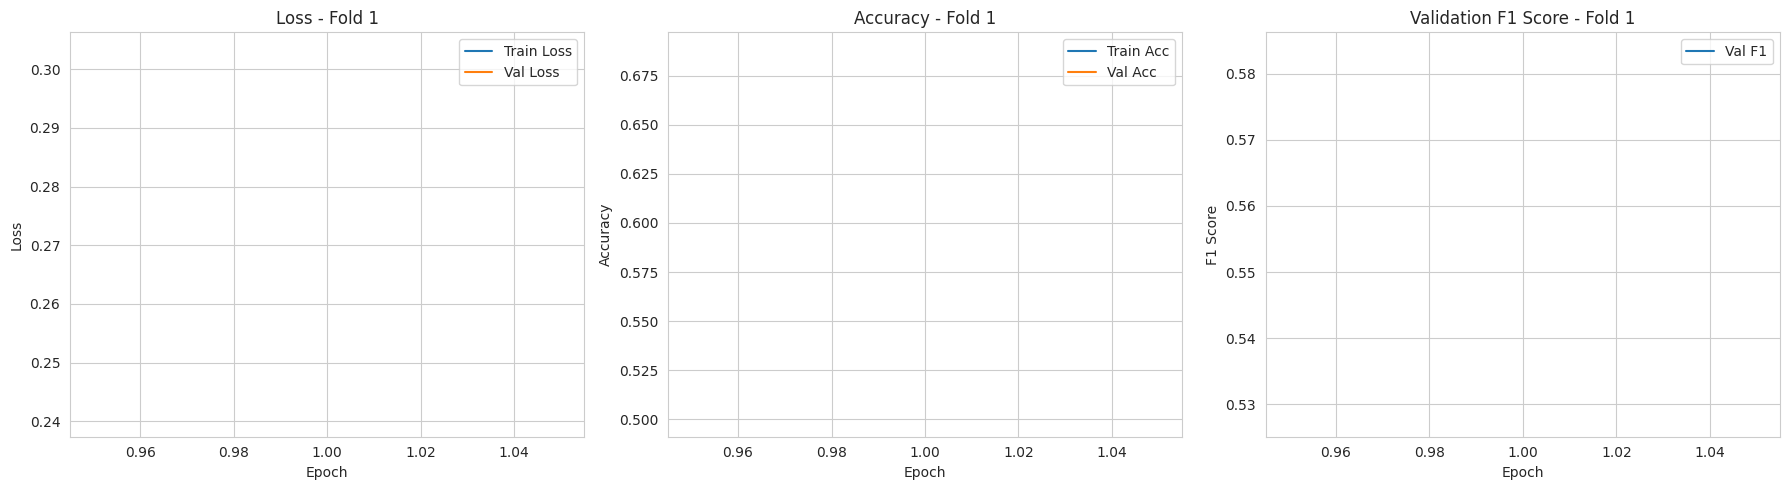

Config 1 mean F1 = 0.5557

=== Running config 2/2: {'model': 'convit_base.fb_in1k', 'lr': 0.0001, 'scheduler': 'cosine'}


Training Epoch 1:  28%|██▊       | 277/1000 [06:17<16:24,  1.36s/it]


KeyboardInterrupt: 

In [ ]:
import timm
import json
from torch.utils.data import DataLoader, Subset
from itertools import product
from sklearn.model_selection import StratifiedKFold

train_y = train_df['label']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_grid = {
    'model': ['efficientnetv2_rw_s.ra2_in1k', 'convit_base.fb_in1k'],
    # 'model': ['efficientnetv2_rw_s.ra2_in1k'],
    'lr':           [1e-4],
    # 'lr':           [3e-4],
    # 'weight_decay': [1e-5],
    # 'hidden_dims':  [(128,64), (256,128), (256,128,64)],
    # 'hidden_dims':  [(256,128,64)],
    'scheduler': ['cosine'],
    # 'dropout':      [0.0, 0.2, 0.5],
    # 'batch_size':   [32, 64],
    # 'use_batchnorm':[True, False],
    # 'patience':     [2, 4]
}


best_overall = {'f1':0.0, 'config':None}

all_configs = []
keys = list(param_grid.keys())
for vals in product(*param_grid.values()):
    cfg = dict(zip(keys, vals))
    all_configs.append(cfg)

train_dataset = MemmapSpectra(specs_train, train_y, spec_train_mean, spec_train_std)
# train_dataset = CustomDataset(train_df, transform=train_transforms)

for i, cfg in enumerate(all_configs):
    print(f"\n=== Running config {i+1}/{len(all_configs)}: {cfg}")
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    fold_f1s = []
    # for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)), train_y), 1):
    train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

    train_ds = Subset(train_dataset, train_idx)
    val_ds   = Subset(train_dataset, val_idx)

    train_loader = DataLoader(
        train_ds,
        batch_size=64,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    f1 = train_fold_timm(train_loader, val_loader, 1, cfg)
    fold_f1s.append(f1)
    mean_f1 = np.mean(fold_f1s)
    print(f"Config {i+1} mean F1 = {mean_f1:.4f}")
    if mean_f1 > best_overall['f1']:
        best_overall = {'f1':mean_f1, 'config':cfg}

print("!!! Best config:", best_overall)

In [ ]:
# Now load the best models and test them on the test set
WEIGHTS_PATH = "/content/best_weights_efficientnetv2_rw_s.ra2_in1k_fold1_lr0.0001_schedcosine.pth"

# Load
model = timm.create_model('efficientnetv2_rw_s.ra2_in1k', pretrained=False, num_classes=2)
model = model.to(device)
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

test_dataset = MemmapSpectra(specs_test, np.zeros(len(test_df)), spec_test_mean, spec_test_std)
# test_dataset = CustomTestDataset(test_df, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# List to store predictions
test_predictions = []

# Disable gradient computation (as we are not training)
with torch.no_grad():
    # Wrap the test_loader with tqdm to display a progress bar
    for data, _ in tqdm(test_loader, desc="Inference Progress", total=len(test_loader)):
        data = data.to(device)
        output = model(data)  # Get model output

        # Get predicted class labels (0 or 1)
        preds = output.argmax(dim=1)  # Get class with highest probability

        # Store predictions
        test_predictions.extend(preds.cpu().numpy())

test_predictions = np.array(test_predictions)

submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["label"] = test_predictions  # Assign 1D predictions

submission_df.to_csv("submission.csv", index=False)

RuntimeError: Error(s) in loading state_dict for EfficientNet:
	size mismatch for conv_stem.weight: copying a param with shape torch.Size([24, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 3, 3, 3]).

label
0    3845
1    1695
Name: count, dtype: int64


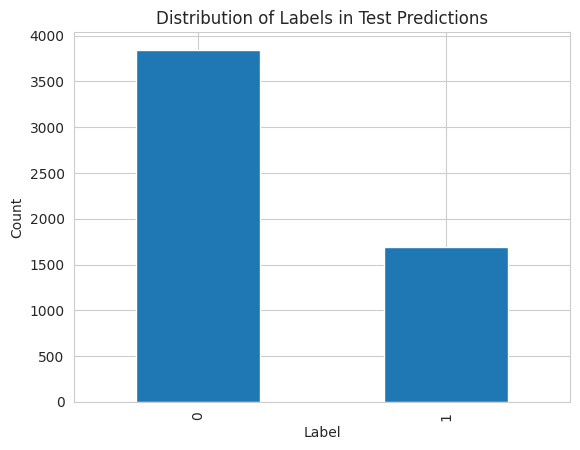

In [ ]:
plot_submission(submission_df)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import svm
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

def init_models():
  dt = DecisionTreeClassifier(random_state=1234)
  perceptron = Perceptron(random_state=1234)
  nb = GaussianNB()
  log_reg = LogisticRegression(random_state=1234, solver='liblinear', multi_class='ovr', max_iter=150)
  svm_linear = svm.SVC(kernel="linear", random_state=1234)
  svm_rbf = svm.SVC(kernel="rbf", random_state=1234)
  gb = HistGradientBoostingClassifier(random_state=1234)
  mlp = MLPClassifier(max_iter=100, solver='adam', early_stopping=True, random_state=1234)
  # svr_poly = svm.SVR(kernel="poly")
  rf = RandomForestClassifier(n_estimators=200, random_state=1234)

  dict_c = {
      "dt": dt,
      "perceptron": perceptron,
      "nb": nb,
      "log_reg": log_reg,
      # "svm_linear": svm_linear,
      # "svm_rbf": svm_rbf,
      "rf": rf,
      "gb": gb,
      "mlp": mlp,
  }


  return dict_c

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
# train_paths = train_df['file_name']
# test_paths = test_df['id']

# # compute class‑averages
# A_train = average_log_spectrum(train_paths, crop_size=(224,224), sigma=3, window=True)
# A_test = average_log_spectrum(test_paths, crop_size=(224,224), sigma=3, window=True)

# r_train, r_test = radial_profile(A_train, nbins=112), radial_profile(A_test, nbins=112)

In [ ]:
df_band_train = pd.DataFrame(band_train)

In [ ]:
df_band_train.head()

band_mean  band_std  band_max  band_centroid
0   7.798190  0.268718  8.182150      19.332040
1   8.063511  0.196262  8.460513      19.379275
2   7.635492  0.104165  7.877676      19.450564
3   8.095327  0.151081  8.275626      19.422460
4   8.529718  0.099680  8.712389      19.455542

In [ ]:
def train_models(models, X_train, X_test, y_train, y_test, m_dict, b_dict):
  def get_metrics(model, X_train, y_train):
    scorer = {
        "precision": metrics.make_scorer(metrics.precision_score, average="macro"),
        "recall": metrics.make_scorer(metrics.recall_score, average="macro"),
        "accuracy": metrics.make_scorer(metrics.accuracy_score),
        "f1": metrics.make_scorer(metrics.f1_score, average="macro")
    }
    cv = cross_validate(model, X_train, y_train, cv=5, scoring=scorer, return_train_score=False, return_estimator=True)
    best_score_index = cv["test_accuracy"].argmax()
    best = cv["estimator"][best_score_index]
    return cv, best


  for key in models.keys():
    # Logging progress to determine which models are taking the most time to process
    print(f"Training model {key}:")
    cv, best = None, None

    cv, best = get_metrics(models[key], X_train, y_train)
    m_dict[key] = cv
    b_dict[key] = best

# Test Models
# lc_dict = learning curves
# bp_dict = best predictions
# sc_dict = best training/testing scores
# pi_dict = permutation importances
def test_models(models, X_train, X_test, y_train, y_test, lc_dict, bp_dict, sc_dict, pi_dict):
  for key in models.keys():
    # Logging progress to determine which models are taking the most time to process
    print(f"Testing model {key}:")
    models[key].fit(X_train, y_train)
    predY = models[key].predict(X_test)

    train_score = models[key].score(X_train, y_train)
    test_score = models[key].score(X_test, y_test)

    lc = learning_curve(estimator=models[key], X=X_test, y=y_test, shuffle=True, scoring='accuracy', random_state=1234)
    imp = permutation_importance(models[key], X_test, y_test, scoring='accuracy', random_state=1234)

    lc_dict[key] = lc
    bp_dict[key] = predY
    sc_dict[key] = (train_score, test_score)
    pi_dict[key] = imp

In [ ]:
def scale_features(X):
  # Leave categorical/boolean data intact
  if (np.min(X) == 0 and np.max(X) == 1):
    return X
  else:
    X = X.reshape(-1, 1)
    return StandardScaler().fit_transform(X)

In [ ]:
df_band_train[df_band_train['band_centroid'].notna() == False]

band_mean  band_std  band_max  band_centroid
752         0.0       0.0       0.0            NaN
2640        0.0       0.0       0.0            NaN
3067        0.0       0.0       0.0            NaN
3695        0.0       0.0       0.0            NaN
3898        0.0       0.0       0.0            NaN
4520        0.0       0.0       0.0            NaN
4918        0.0       0.0       0.0            NaN

In [ ]:
# Drop rows with null values in 'band_centroid' and corresponding labels
df_band_train = df_band_train.dropna()
train_y = train_y[df_band_train.index]


In [ ]:
for col in df_band_test.columns:
  df_band_test[col] = df_band_test[col].fillna(df_band_test[col].mean())


In [ ]:
X, y = pd.DataFrame(X_np), train_df['label']

NameError: name 'X_np' is not defined

In [ ]:
X.head()

0         1         2         3         4         5         6    \
0  6.530686  6.649625  6.864464  6.946301  7.430988  7.927676  8.081868   
1  6.496041  6.875684  7.313196  7.489156  7.850059  7.747657  8.107008   
2  7.333923  7.467365  7.660776  7.585515  7.688782  7.750365  7.722324   
3  6.869972  6.793739  7.000493  7.757381  8.117128  8.339061  8.080950   
4  6.670843  6.868701  6.458643  7.343409  7.753344  8.100041  8.411578   

        7         8         9    ...       102       103       104       105  \
0  8.170711  8.245104  8.149528  ...  5.240800  5.234076  5.260724  5.217916   
1  7.782419  8.058071  8.105325  ...  5.548420  5.529217  5.510955  5.398292   
2  8.066703  7.904659  7.833720  ...  5.615365  5.598699  5.521114  5.572695   
3  7.995178  8.336953  8.320089  ...  5.638040  5.683350  5.716799  5.640907   
4  8.357547  8.150135  8.514945  ...  6.148491  6.158297  6.099790  6.063377   

        106       107       108       109       110       111  
0  5.299144  5.242774  5.168526  5.140128  5.160733  5.111038  
1  5.412134  5.387220  5.385998  5.377101  5.368550  5.363876  
2  5.528584  5.487969  5.471475  5.415808  5.522549  5.446340  
3  5.592046  5.463454  5.569186  5.558495  5.527454  5.459378  
4  6.011078  5.938964  5.925626  5.894083  5.833720  5.884787  

[5 rows x 112 columns]

In [ ]:
def pipe(X, y):
  train_sizes = [0.7]
  # learning_curves and metrics are arrays of 3 dictionaries each.
  # Each dictionary will hold the learning curve and metrics data for each model in each fold.
  learning_curves = np.array([{}, {}, {}])
  m_metrics = np.array([{}, {}, {}])
  models = {}
  best_models = np.array([{}, {}, {}])
  best_scores = np.array([{}, {}, {}])
  best_predictions = np.array([{}, {}, {}])
  permutation_importances = np.array([{}, {}, {}])
  true_y = []

  for i in range(len(train_sizes)):
    print(f"Begin loop on train size {train_sizes[i]}:")
    models = init_models()

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_sizes[i], random_state=1234)

    # X_train = preprocess(X_train)
    # X_test = preprocess(X_test)

    for col_label, col_data in X_train.items():
      X_train[col_label] = scale_features(col_data.values)

    for col_label, col_data in X_test.items():
      X_test[col_label] = scale_features(col_data.values)

    true_y.append(y_test)


    # Test with 1 model
    train_models(models, X_train, X_test, y_train, y_train, m_metrics[i], best_models[i])

    # Now train the best models on the whole training set

    test_models(best_models[i], X_train, X_test, y_train, y_test, learning_curves[i], best_predictions[i], best_scores[i], permutation_importances[i])

    # print(f"Best prediction data for sample {i}:")
    # print(best_predictions[i])



  return learning_curves, m_metrics, best_models, best_predictions, best_scores, true_y, permutation_importances






learning_curves, m_metrics, best_models, best_predictions, best_scores, true_y, permutation_importances = pipe(X, y)

Begin loop on train size 0.7:
Training model dt:
Training model perceptron:
Training model nb:
Training model log_reg:
Training model rf:
Training model gb:
Training model mlp:
Testing model dt:
Testing model perceptron:
Testing model nb:
Testing model log_reg:
Testing model rf:


In [ ]:
def n_to_split(n):
  if n == 0:
    return "70/30"
  if n == 1:
    return "70/30"
  if n == 2:
    return "80/20"
  else:
    return ""

def key_to_name(key):
  if key == "dt":
    return "Decision Tree"
  if key == "perceptron":
    return "Perceptron"
  if key == "nb":
    return "Naive Bayes"
  if key == "log_reg":
    return "Logistic Regression"
  if key == "svm_linear":
    return "SVM (Linear)"
  if key == "svm_rbf":
    return "SVM (RBF)"
  if key == "gb":
    return "Gradient Boosting"
  if key == "mlp":
    return "Multi-Layer Perceptron"
  if key == "rf":
    return "Random Forest"


  else:
    return ""

In [ ]:
from IPython.display import HTML
from pandas.io.formats.style import Styler

model_tables = []
captions = []
for sample in range(1):
  model_cols = []
  model_rows = []
  for key in m_metrics[sample]:
    model_cols = []
    model_row = {}
    for fold in range(10):
      model_id = f"{key} {fold+1}"
      model_cols.append(model_id)
    model_row = {'Precision': m_metrics[sample][key]['test_precision'],
                    'Recall': m_metrics[sample][key]['test_recall'],
                    'F1': m_metrics[sample][key]['test_f1'],
                    'Accuracy': m_metrics[sample][key]['test_accuracy']}
      # print(model_row['Precision'])
    table = pd.DataFrame(columns=model_cols, data=model_row.values(), index=model_row.keys())
    # Add table caption
    captions.append(f"{n_to_split(sample)} Split, {key_to_name(key)}")
    table = table.round(4)
    model_tables.append(table)



for i, t in enumerate(model_tables):
  t = Styler(t, caption=captions[i], precision=4)
  display(t)
  display(HTML("<br style margin-bottom:50px>"))

In [ ]:
print(learning_curves[0].keys())

In [ ]:
def show_learning_curve(ax, lc_sizes, train_scores, valid_scores, title, n, metric):
  split = ""
  color = ""
  if n == 0:
    split = "70/30"
    color = "blue"
  if n == 1:
    split = "70/30"
    color = "magenta"
  if n == 2:
    split = "80/20"
    color = "orange"
  max_size = max(lc_sizes)
  train_mean = train_scores.mean(axis=1)
  valid_mean = valid_scores.mean(axis=0)
  ax.plot(lc_sizes / max_size, train_mean, linestyle="solid", color=color, label = f"Training Score ({split} Split)")
  ax.plot(lc_sizes / max_size, valid_mean, linestyle="dashdot", color=color, label = f"Validation Score ({split} Split)")
  ax.set_title(title)
  ax.set_ylabel(metric)
  ax.set_xlabel("% of Samples")


f, ax = plt.subplots(3, 4, figsize = (16, 8))

ax_y = 0
ax_x = 0
for key in learning_curves[0].keys():
  # Fill out one plot
  for sample in range(1):
    sizes, train_scores, test_scores = learning_curves[sample][key]
    metric = "Accuracy Score"
    # if is_regressor(key):
    #   metric = "R2 Score"
    show_learning_curve(ax[ax_y][ax_x], sizes, train_scores, test_scores, key, sample, metric)
  ax_x = ax_x + 1
  if ax_x >= len(ax[ax_y]):
    ax[ax_y][ax_x-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax_y = ax_y + 1
    ax_x = 0
# f.delaxes(ax[1][3])
plt.subplots_adjust(wspace=1.0, hspace=0.5)

In [ ]:
def get_best_metrics(key, sample):
  best_index = m_metrics[sample][key]['test_f1'].argmax()
  return {
      'accuracy': m_metrics[sample][key]['test_accuracy'][best_index],
      'recall': m_metrics[sample][key]['test_recall'][best_index],
      'precision': m_metrics[sample][key]['test_precision'][best_index],
      'f1': m_metrics[sample][key]['test_f1'][best_index]
  }

def get_best_predict(key, sample):
  return best_predictions[sample][key]

In [ ]:
# Find the best model

top3models = []
# def sort_models(m):
#   return m[1]
print(best_scores)
for d in best_scores:
  max_key = ""
  max_val = 0
  for k in d.keys():
    if d[k][1] > max_val:
      max_val = d[k][1]
      max_key = k
  top3models.append((max_key, max_val))
  break


# top3models.sort(reverse=True, key=sort_models)
print(top3models)

winner = top3models[0]
for i in range(len(top3models)):
  max_idx = 0
  max_key = ""
  max_val = 0
  if top3models[i][1] > max_val:
    max_idx = i
    max_val = top3models[i][1]
    max_key = top3models[i][0]
  winner = (max_idx, max_key, max_val)
  break
# print("Best model:")
# print(winner)

best_stats = get_best_metrics(winner[1], winner[0])

best_p = get_best_predict(winner[1], winner[0])

win_sample = winner[0]
win_key = winner[1]




# for i in range(len(m_metrics[2]['gb']['estimator'])):
#   if winner_model is m_metrics[2]['gb']['estimator'][i]:
#     print(i)
#     break
best_stats['Sample'] = n_to_split(win_sample)
best_stats['Model'] = key_to_name(win_key)

accuracy = metrics.accuracy_score(true_y[winner[0]], best_predictions[win_sample][win_key])
precision = metrics.precision_score(true_y[win_sample], best_predictions[win_sample][win_key], average="macro")
recall = metrics.recall_score(true_y[win_sample], best_predictions[win_sample][win_key], average="macro")
f1 = metrics.f1_score(true_y[win_sample], best_predictions[win_sample][win_key], average="macro")

best_stats_table = pd.DataFrame({'Training Metrics': best_stats.values(), 'Testing Metrics': [accuracy, precision, recall, f1, ' ', ' ']}, index=best_stats.keys()).round(4)
best_stats_table = best_stats_table.reindex(['Sample', 'Model', 'accuracy', 'recall', 'precision', 'f1'])

display(Styler(best_stats_table, caption="Best Model", precision=4))

winner_model = best_models[winner[0]][winner[1]]
# print("Best model's CM:")
cnf_matrix = metrics.confusion_matrix(true_y[winner[0]], best_p)
print(cnf_matrix)

ax = plt.subplot(1, 1, 1)
ax.grid(False)
cnf_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = winner_model.classes_)
cnf_display.plot(ax=ax)
ax.set_title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
# Test best model
X_test = test_df.copy()
for col_label, col_data in X_test.items():
      X_test[col_label] = scale_features(col_data.values)

test_predictions = winner_model.predict(spect_test_features)

test_predictions = np.array(test_predictions)

submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["label"] = test_predictions


submission_df.to_csv("submission.csv", index=False)

In [ ]:
plot_submission(submission_df)


In [ ]:
# This model needs to be fixed

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

fractal_levels = 4

# Step 1: Function to extract noise residual from an image.
def extract_noise_residual(image: np.ndarray, kernel_size: int = 7) -> np.ndarray:
    """
    Applies a median blur and subtracts it from the original to get noise residual.

    Args:
        image: A numpy array representing the image (H, W, C) in uint8 or float32.
        kernel_size: Size of the median filter.

    Returns:
        noise residual with same shape as image.
    """
    # OpenCV medianBlur expects 8-bit images; if float, scale accordingly or convert.
    blurred = cv2.medianBlur(image, kernel_size)
    residual = image.astype(np.float32) - blurred.astype(np.float32)
    return residual

# Step 2: Function to compute normalized FFT magnitude for each channel.
def compute_normalized_fft_magnitude(noise_residual: np.ndarray) -> np.ndarray:
    """
    Computes the FFT for each channel and returns the normalized magnitude spectrum.

    Args:
        noise_residual: A numpy array of shape (H, W, C).

    Returns:
        A numpy array of the same shape representing the normalized magnitude spectrum.
    """
    H, W, C = noise_residual.shape
    mag_spectrums = np.zeros((H, W, C), dtype=np.float32)

    for c in range(C):
        # FFT expects 2D input.
        fft_result = np.fft.fft2(noise_residual[:, :, c])
        fft_shift = np.fft.fftshift(fft_result)
        magnitude = np.abs(fft_shift)
        # Normalize: here we can use min-max normalization or simply divide by max.
        if magnitude.max() != 0:
            magnitude = magnitude / magnitude.max()
        mag_spectrums[:, :, c] = magnitude
    return mag_spectrums

# Helper module: Convolution block with instance norm and LeakyReLU
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.inst_norm = nn.InstanceNorm2d(out_channels)
        self.activation = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.inst_norm(x)
        x = self.activation(x)
        return x

# Module for fractal branch processing.
class FractalBranchModule(nn.Module):
    def __init__(self, in_channels=1, num_feature_maps=32):
        super(FractalBranchModule, self).__init__()
        # A simple conv block for the branch
        self.conv_block = ConvBlock(in_channels, num_feature_maps)

    def forward(self, x):
        # x assumed to be one fractal branch (one quadrant) input.
        return self.conv_block(x)

# Module that fuses the four fractal branches.
class FractalFusionModule(nn.Module):
    def __init__(self, num_feature_maps=32, output_dim=128):
        super(FractalFusionModule, self).__init__()
        # Convolution after element-wise product fusion.
        self.conv = ConvBlock(num_feature_maps, num_feature_maps)
        # Pooling and FC to produce a vector. Adjust pooling parameters as needed.
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_feature_maps, output_dim)

    def forward(self, branch_features):
        """
        Expects branch_features as a list of 4 feature maps of identical size.
        Performs element-wise product fusion then convolution, pooling, and FC.
        """
        # Element-wise product: start with first branch then multiply with others.
        fused = branch_features[0]
        for feat in branch_features[1:]:
            fused = fused * feat
        # Further processing with a convolutional layer.
        conv_out = self.conv(fused)
        pooled = self.pool(conv_out)  # shape: [B, num_feature_maps, 1, 1]
        pooled = pooled.view(pooled.size(0), -1)  # shape: [B, num_feature_maps]
        vector = self.fc(pooled)
        return vector

# The overall CNN classifier that integrates the fractal feature extraction.
class FractalCNNClassifier(nn.Module):
    def __init__(self, num_feature_maps=32, feature_dim=128, num_classes=2):
        super(FractalCNNClassifier, self).__init__()
        # We assume 3-channel FFT input; we treat each channel separately.
        # In our implementation, for the FFT part we assume the magnitude spectrum is computed outside.
        # The fractal branch module works on one channel at a time.
        self.num_feature_maps = num_feature_maps
        self.feature_dim = feature_dim

        # Four branch modules for each fractal branch processing for the first level
        self.branch_module = FractalBranchModule(in_channels=1, num_feature_maps=num_feature_maps)
        self.fusion_module = FractalFusionModule(num_feature_maps=num_feature_maps, output_dim=feature_dim)

        # Second level: the self-similarity vector from the average spectrum
        # self.branch_module2 = FractalBranchModule(in_channels=1, num_feature_maps=num_feature_maps)
        # self.fusion_module2 = FractalFusionModule(num_feature_maps=num_feature_maps, output_dim=feature_dim)

        # Fully connected module that takes concatenated vectors (e.g., S0 and S1)
        self.fc_final = nn.Sequential(
            nn.Linear(feature_dim * (fractal_levels + 1), 64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(64, num_classes)
        )

    def split_into_branches(self, spectrum):
        """
        Splits a single-channel spectrum into 4 quadrants (branches).
        Args:
            spectrum: Tensor of shape [B, 1, H, W]
        Returns:
            A list of 4 tensors each of shape [B, 1, H/2, W/2]
        """
        B, C, H, W = spectrum.size()
        h_mid = H // 2
        w_mid = W // 2
        branch1 = spectrum[:, :, :h_mid, :w_mid]
        branch2 = spectrum[:, :, :h_mid, w_mid:]
        branch3 = spectrum[:, :, h_mid:, :w_mid]
        branch4 = spectrum[:, :, h_mid:, w_mid:]
        return [branch1, branch2, branch3, branch4]

    def get_self_similarity(self, branches):
        """
        Processes the spectrum: splits into fractal branches and fuses them.
        Args:
            spectrum: Tensor of shape [B, 1, H, W]
        Returns:
            A feature vector from fusion.
        """
        # branches = self.split_into_branches(spectrum)
        # Process each branch with the same branch module
        processed_branches = [self.branch_module(branch) for branch in branches]
        # Fuse the branch outputs into one vector S (e.g., S0 or S1)
        S = self.fusion_module(processed_branches)
        return S

    def forward(self, H_spect):
        """
        Forward pass expects fft_mag of shape [B, C, H, W], where C = 3.
        """
        B, C, H, W = H_spect.size()
        S_vectors = []
        all_branches = []
        S_list = []

        # Process each channel separately
        for c in range(C):
            channel_spectrum = H_spect[:, c:c+1, :, :]  # shape: [B, 1, H, W]
            branches = self.split_into_branches(channel_spectrum)  # list of 4 [B, 1, H/2, W/2]
            all_branches.append(branches)

            # First-level processing (S0)
            S = self.get_self_similarity(branches)
            S_vectors.append(S)

        # Average S0 vectors across channels
        S0 = torch.stack(S_vectors, dim=0).mean(dim=0)
        S_list.append(S0)

        # Construct H1 using average of all 4 branches from all 3 channels
        all_branches = list(zip(*all_branches))  # shape: 4 lists, each with 3 [B, 1, H/2, W/2]
        avg_branches = []
        for branch_group in all_branches:
            # branch_group is a tuple of 3 [B, 1, H/2, W/2] tensors (one from each channel)
            stacked = torch.stack(branch_group, dim=0)  # shape: [3, B, 1, H/2, W/2]
            avg = stacked.mean(dim=0)  # shape: [B, 1, H/2, W/2]
            avg_branches.append(avg)

        # Upsample each avg_branch to [B, 1, H, W]
        upsampled_branches = [F.interpolate(branch, size=(H, W), mode='bilinear', align_corners=False) for branch in avg_branches]
        # print(upsampled_branches[0].shape)

        # Compute H1 as average of upsampled branches
        H_spect = torch.stack(upsampled_branches, dim=0).mean(dim=0)  # shape: [B, 1, H, W]
        # print(H_spect.shape)

        # Level 2 processing (S1)
        for _ in range(fractal_levels):
            branches = self.split_into_branches(H_spect)  # 4 branches from previous avg_spectrum
            processed_branches = [self.branch_module(branch) for branch in branches]
            S = self.fusion_module(processed_branches)
            S_list.append(S)

            # Prepare avg_spectrum for next level
            H_spect = torch.stack([
                F.interpolate(branch, size=(H, W), mode='bilinear', align_corners=False)
                for branch in branches
            ], dim=0).mean(dim=0)  # shape: [B, 1, H, W]


        # Final classification
        multi_level_feature = torch.cat(S_list, dim=1)
        out = self.fc_final(multi_level_feature)
        return out

# Example usage:

# Assume you load an image using OpenCV. The image should be in BGR or RGB format.
image_path = train_df.iloc[15]["file_name"]
image = cv2.imread(image_path)  # shape: (H, W, 3) in BGR by default
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB if needed

# Step 1: Compute noise residual.
noise_residual = extract_noise_residual(image, kernel_size=7)

# Step 2: Compute normalized magnitude spectrum via FFT (per channel).
fft_magnitude = compute_normalized_fft_magnitude(noise_residual)

# Convert fft_magnitude to torch tensor and add batch dimension.
fft_magnitude = torch.from_numpy(fft_magnitude).permute(2, 0, 1).unsqueeze(0)  # shape [1, 3, H, W]

# Instantiate the classifier.
model = FractalCNNClassifier(num_feature_maps=32, feature_dim=128, num_classes=2)

# Forward pass: returns logits for class prediction (0: real, 1: AI-generated).
logits = model(fft_magnitude)
prediction = torch.argmax(logits, dim=1)

print("Logits:", logits)
print("Predicted class:", prediction.item())
print("Actual class:", train_df.iloc[15]["label"])


Logits: tensor([[ 0.0009, -0.0208]], grad_fn=<AddmmBackward0>)
Predicted class: 0
Actual class: 0


In [ ]:
# N in the fractal self-similarity paper
fractal_levels = 4
input_shape = (224, 224, 1) # 1 channel = grayscale

def get_fractal_self_similarity(image):
    H = image
    S_list = []
    for _ in range(fractal_levels):
        I_res = compute_noise_residual(H)
        H0 = compute_normalized_spectrum(I_res)
        S, H = fractal_module(H0, filters=32)
        S = layers.Lambda(lambda x: tf.image.resize(x, [input_shape[0], input_shape[1]]), output_shape=(input_shape[0], input_shape[1], 32))(S)
        S_list.append(S)

    concat_features = layers.Concatenate(axis=-1)(S_list)
    return concat_features

def create_model():
    inputs = layers.Input(shape=input_shape)

    H = inputs
    S_list = []
    for _ in range(fractal_levels):
        I_res = compute_noise_residual(H)
        H = compute_normalized_spectrum(I_res)
        S, H = fractal_module(H, filters=32)
        S = layers.Lambda(lambda x: tf.image.resize(x, [input_shape[0], input_shape[1]]), output_shape=(input_shape[0], input_shape[1], 32))(S)
        S_list.append(S)

    concat_features = layers.Concatenate(axis=-1)(S_list)
    # concat_features = get_fractal_self_similarity(inputs)

    # ----- Classification Module -----
    x = layers.Flatten()(concat_features)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the final model.
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
class F1CheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, save_path):
        super().__init__()
        self.val_data = val_data
        self.save_path = save_path
        self.best_f1 = 0.0

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for x_batch, y_batch in self.val_data:
            preds = self.model.predict(x_batch)
            preds_binary = np.round(preds).astype(int).flatten()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds_binary)

        current_f1 = f1_score(y_true, y_pred)
        print(f"🔍 Epoch {epoch+1} F1 Score: {current_f1:.4f}")

        if current_f1 > self.best_f1:
            print(f"New best F1: {current_f1:.4f}, saving model to {self.save_path}")
            self.best_f1 = current_f1
            self.model.save(self.save_path)

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score

num_folds = 3
epochs = 5
batch_size = 32
input_shape = (224, 224, 3)

image_paths = train_df['file_name'].values
labels = train_df['label'].values

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

models_list = []

fold = 1
for train_index, val_index in kf.split(image_paths, labels):
    print(f"\n Training fold {fold}...")

    train_paths, val_paths = image_paths[train_index], image_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    model = create_model()
    checkpoint_path = f"best_model_fold_{fold}.keras"
    f1_callback = F1CheckpointCallback(val_data=val_ds, save_path=checkpoint_path)
    # checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    #     filepath=checkpoint_path,
    #     save_weights_only=False,
    #     monitor='val_loss',
    #     mode='min',
    #     save_best_only=True
    # )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    )
    models_list.append(model)
    model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[f1_callback, early_stopping])
    fold += 1

NameError: name 'train_df' is not defined

In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/best_model_fold_1.keras"
model = load_model(model_path)
model.summary()

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 112, 112, 32), dtype=float32, sparse=False, name=keras_tensor_555>',)
  • kwargs={'mask': 'None'}

In [ ]:
# Training Transformations (with Augmentation)
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Testing Transformations (NO Augmentation)
test_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

In [ ]:
# It's timm time
import timm
import torch.nn as nn
from pprint import pprint
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

model_names = timm.list_models(pretrained=True)
print(model_names)

['aimv2_1b_patch14_224.apple_pt', 'aimv2_1b_patch14_336.apple_pt', 'aimv2_1b_patch14_448.apple_pt', 'aimv2_3b_patch14_224.apple_pt', 'aimv2_3b_patch14_336.apple_pt', 'aimv2_3b_patch14_448.apple_pt', 'aimv2_huge_patch14_224.apple_pt', 'aimv2_huge_patch14_336.apple_pt', 'aimv2_huge_patch14_448.apple_pt', 'aimv2_large_patch14_224.apple_pt', 'aimv2_large_patch14_224.apple_pt_dist', 'aimv2_large_patch14_336.apple_pt', 'aimv2_large_patch14_336.apple_pt_dist', 'aimv2_large_patch14_448.apple_pt', 'bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'b

Model card for convit_base.fb_in1k:
https://huggingface.co/timm/convit_base.fb_in1k/blame/c93eea8ccd421f7e9a7baa1a8357b15ad7246ec5/README.md

It's a ConViT model trained on the ImageNet-1k dataset.
https://arxiv.org/abs/2103.10697

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import json
from itertools import product
from sklearn.model_selection import StratifiedKFold, KFold
from scipy.ndimage import gaussian_filter


class SpectralDataset(Dataset):
    def __init__(self, file_paths, labels,
                 crop_size=(224,224), sigma=3,
                 window=True, transform=None, is_test=False):
        self.paths = file_paths
        self.labels = labels
        self.crop_size = crop_size
        self.sigma = sigma
        self.window = window
        self.transform = transform
        # precompute a Hann window once
        self.hann = make_2d_hann(*crop_size) if window else None
        self.is_test = is_test

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
         # 1) load & crop
        img = cv2.imread(self.paths[idx], cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img = center_crop(img, self.crop_size)
        # 2) highpass
        hp = highpass(img, sigma=self.sigma)
        # 3) optional window
        if self.window:
            hp = hp * self.hann
        # 4) FFT → log‑mag
        F = np.fft.fftshift(np.fft.fft2(hp))
        logmag = np.log1p(np.abs(F))
        # 5) normalize (per‑sample)
        logmag = (logmag - logmag.mean()) / (logmag.std() + 1e-8)
        # 6) to torch tensor, add channel dim
        tensor = torch.from_numpy(logmag).unsqueeze(0)  # shape [1,H,W]
        label  = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            augmented = self.transform(image=logmag)
            tensor = augmented['image']


        return tensor, label

class CustomDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = pd.DataFrame(df)
        self.transform = transform
        self.is_test = is_test
        self.df["label"] = self.df["label"].astype(float)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # img_path = self.df.iloc[idx]["file_name"]
        img_path = self.df.iloc[idx]['id' if self.is_test else 'file_name']
        img = Image.open(img_path)

        if self.transform:
            # img = self.transform(img)
            img = self.transform(img)

        if self.is_test:
          # 0 is a dummy value to make unpacking easier
            return img, 0.0
        else:
            label = self.df.iloc[idx]["label"]
            return img, label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = ['efficientnetv2_rw_s.ra2_in1k', 'timm/swinv2_large_window12_192.ms_in22k', 'convit_base.fb_in1k']
lrs = [1e-4, 1e-5]
schedulers = ['cosine', 'step', 'plateau']
epochs = 5
patience = 2
epochs_without_improvement = 0
best_val_loss = float('inf')
pos_weight = 0.4

num_workers = 2

results = {}
overall_best_f1 = 0.0
overall_best_config = None

def setup_params(model, lr, sched):
    global optimizer, criterion, scheduler  # so `train()` can access them

    pw = torch.tensor([pos_weight]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pw)

    # Get classifier or head parameters
    if hasattr(model, 'head'):
        head_params = list(model.head.parameters())
        other_params = [p for n, p in model.named_parameters() if "head" not in n]
    elif hasattr(model, 'classifier'):
        head_params = list(model.classifier.parameters())
        other_params = [p for n, p in model.named_parameters() if "classifier" not in n]
    else:
        raise ValueError("Model has neither 'head' nor 'classifier'")

    # Remove duplicates (sometimes they still overlap due to name mapping)
    head_ids = {id(p) for p in head_params}
    other_params = [p for p in model.parameters() if id(p) not in head_ids]

    optimizer = optim.AdamW([
        {"params": head_params, "lr": lr},
        {"params": other_params, "lr": lr}
    ], weight_decay=1e-2)

    scheduler = get_scheduler(optimizer, sched)
    criterion = criterion.to(device)

    print("AdamW Optimizer & Scheduler initialized")

def load_data(model):
    global train_loader, val_loader

    config = resolve_data_config({}, model=model, use_test_size=True)
    image_size = config['input_size'][-1]  # Usually (3, H, W), we take H/W
    transform = create_transform(**config)

    print("Expected input size:", config['input_size'])  # Add debug line

    # Override transform to be explicit and safe
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB')),
        transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.Normalize(
            mean=config['mean'],
            std=config['std']
        )
    ])

    train_dataset = CustomDataset(train_df, transform)
    val_dataset = CustomDataset(val_df, transform)  # Make sure is_test is False to read actual labels.

    train_loader = DataLoader(train_dataset, batch_size=8, num_workers=num_workers, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, num_workers=num_workers, shuffle=False, pin_memory=True)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    model.eval()
    with torch.no_grad():
        for data, _ in train_loader:
            data = data.to(device)
            print(f"Image shape after transform: {data.shape}")
            output = model(data)  # this is where it would fail
            print("Model Output Shape:", output.shape)
            break
    return

def get_scheduler(optimizer, name):
    if name == 'cosine':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    elif name == 'step':
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif name == 'plateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    else:
        return None



def train(model, train_loader, val_loader, fold):
    global overall_best_f1, overall_best_config

    # Initialize lists to store loss, accuracy, and F1 scores
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1s = []

    best_f1 = 0.0
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Train the model
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device).float()  # Convert label to float

            optimizer.zero_grad()
            output = model(data).squeeze(1)  # Forward pass (squeeze to remove extra dim)
            loss = criterion(output, label)  # Compute loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            sigmoids = torch.sigmoid(output)
            preds = (sigmoids > 0.5).float()  # Convert logits to binary (0 or 1)
            acc = (preds == label).float().mean().item()  # Compute accuracy
            epoch_accuracy += acc
        print(f"Mean prediction:{sigmoids.mean()}")
        # print("Unique values in predictions:", np.unique(preds)) # error
        # print("Unique values in labels:", np.unique(val_labels_list))

        epoch_loss /= len(train_loader)
        epoch_accuracy /= len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # -- Validation --
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_pred_classes = []
        val_labels_list = []

        with torch.no_grad():
            for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                data, label = data.to(device), label.to(device).float()
                output = model(data).squeeze(1)
                loss = criterion(output, label)
                val_loss += loss.item()
                sigmoids = torch.sigmoid(output)
                preds = (sigmoids > 0.5).float()  # still a float tensor of 0.0 and 1.0
                acc = (preds == label).float().mean().item()
                val_acc += acc

                # Convert to numpy arrays and then to int
                preds_np = preds.cpu().numpy().astype(int)
                labels_np = label.cpu().numpy().astype(int)

                val_pred_classes.extend(preds_np)
                val_labels_list.extend(labels_np)
            print(f"Mean prediction:{sigmoids.mean()}")
            print("Unique values in predictions:", np.unique(val_pred_classes))
            print("Unique values in labels:", np.unique(val_labels_list))


        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Calculate F1 Score
        val_f1 = f1_score(val_labels_list, val_pred_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        # Print progress
        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
        )


        # Early Stopping Logic
        # Check improvement
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_val_loss = val_loss
            epochs_without_improvement = 0

            config_tag = f"{model_name}_lr{lr}_sched-{sched}_fold{fold+1}"
            torch.save(model.state_dict(), f"best_weights_{config_tag}.pth")
            torch.save(model, f"best_model_{config_tag}.pt")
            print(f"Model saved with best F1: {best_f1:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No improvement at epoch {epoch+1}")

        if sched == 'plateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()
        if epochs_without_improvement >= patience:
            print(f"Stopped early at epoch {epoch+1}")
            break
        model.eval()

    # Save results
    config_key = f"{model_name}_lr{lr}_sched-{sched}"
    results[config_key] = {
        "best_f1": best_f1,
        "lr": lr,
        "scheduler": sched,
        "model": model_name,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_f1s": val_f1s,
        "fold": fold+1
    }

    if best_f1 > overall_best_f1:
        overall_best_f1 = best_f1
        overall_best_config = config_key


    with open("model_f1_results.json", "w") as f:
        json.dump(results, f, indent=4)

    print(f"\n Best config so far: {overall_best_config} with F1 = {overall_best_f1:.4f}")


def has_pretrained_weights(model_name):
    pretrained_cfg = timm.models.get_pretrained_cfg(model_name)
    return pretrained_cfg is not None

# MAIN PIPELINE LOOP
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_f1s = []

# X = train_df["file_name"].values
# y = train_df["label"].values
X = specs_train["file_name"].values
y = specs_train["label"].values

for model_name, lr, sched in product(models, lrs, schedulers):
    print(f"Training {model_name} with LR={lr} and Scheduler={sched}")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
        train_paths, val_paths = X[train_index], X[val_index]
        train_labels, val_labels = y[train_index], y[val_index]
        # train_ds = SpectralDataset(train_paths, train_labels, transform=train_transforms)
        # val_ds = SpectralDataset(val_paths, val_labels, transform=test_transforms)
        train_ds = TensorDataset(torch.tensor(train_paths), torch.tensor(train_labels))
        val_ds = TensorDataset(torch.tensor(val_paths), torch.tensor(val_labels))

        train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)


        if has_pretrained_weights(model_name):
            print(f"Loading pretrained weights for {model_name}")
            model = timm.create_model(model_name, pretrained=True, num_classes=1, in_chans=1)
        else:
            print(f"No pretrained weights found for {model_name}")
            model = timm.create_model(model_name, pretrained=False, num_classes=1, in_chans=1)

        print(model.default_cfg['input_size'])

        model = model.to(device)

        # load_data(model)
        # print(f"Train dataset size: {len(train_dataset)}")
        # print(f"Validation dataset size: {len(val_dataset)}")
        # model.eval()
        # with torch.no_grad():
        #     for data, _ in train_loader:
        #         data = data.to(device)
        #         output = model(data)

        #     for data, _ in val_loader:
        #         data = data.to(device)
        #         output = model(data)


        setup_params(model, lr, sched)

        train(model, train_loader, val_loader, fold)
print(f"\n Best overall config: {overall_best_config} with F1 = {overall_best_f1:.4f}")
torch.cuda.empty_cache()

Training efficientnetv2_rw_s.ra2_in1k with LR=0.0001 and Scheduler=cosine
Loading pretrained weights for efficientnetv2_rw_s.ra2_in1k
(3, 288, 288)
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 7995/7995 [19:39<00:00,  6.78it/s]


Mean prediction:0.5481052398681641


Validation Epoch 1: 100%|██████████| 1999/1999 [02:38<00:00, 12.60it/s]


Mean prediction:0.34037017822265625
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.3319 | Train Acc: 0.6958 | Val Loss: 7450.8775 | Val Acc: 0.8196 | Val F1: 0.8243
Model saved with best F1: 0.8243


Training Epoch 2:   2%|▏         | 171/7995 [00:25<19:06,  6.82it/s]


KeyboardInterrupt: 

In [ ]:
PATH = "/content/best_model_efficientnetv2_rw_s.ra2_in1k_lr0.0001_sched-step.pt"
os.path.exists(PATH)

True

In [ ]:
# Now load the best models and test them on the test set
# With Colab Pro A100, EfficientNetV2 takes about 4 minutes to predict the whole test set.
WEIGHTS_PATH = "/content/best_weights_efficientnetv2_rw_s.ra2_in1k_lr0.0001_sched-cosine_fold2.pth"

def load_test_data(model):
    global test_loader
    config = resolve_data_config({}, model=model, use_test_size=True)
    image_size = config['input_size'][-1]  # Usually (3, H, W), we take H/W
    transform = create_transform(**config)

    print("Expected input size:", config['input_size'])  # Add debug line

    # Override transform to be explicit and safe
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB')),
        transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config['mean'],
            std=config['std']
        )
    ])
    test_dataset = CustomDataset(test_df, transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load
model = timm.create_model('efficientnetv2_rw_s.ra2_in1k', pretrained=False, num_classes=1, in_chans=1)
model = model.to(device)
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

# load_test_data(model)
X_test = test_df['id'].values
y_test = np.zeros(len(test_df))
test_dataset = SpectralDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# List to store predictions
test_predictions = []

# Disable gradient computation (as we are not training)
with torch.no_grad():
    # Wrap the test_loader with tqdm to display a progress bar
    for data, _ in tqdm(test_loader, desc="Inference Progress", total=len(test_loader)):
        data = data.to(device).type(torch.float32)
        output = model(data).squeeze(1)  # Ensure correct dimensions

        # Apply sigmoid activation to convert logits to probabilities
        probs = torch.sigmoid(output)

        # Convert probabilities to binary class (0 or 1) using threshold 0.5
        preds = (probs > 0.5).int()

        # Store predictions
        test_predictions.extend(preds.cpu().numpy())

test_predictions = np.array(test_predictions)

submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["label"] = test_predictions


submission_df.to_csv("submission.csv", index=False)

Inference Progress: 100%|██████████| 693/693 [02:39<00:00,  4.35it/s]


In [ ]:
plot_submission(submission_df)

NameError: name 'plot_submission' is not defined